# DSFB 2019 Project - Team 3: Solutions

Team members:
![image.png](attachment:image.png)

## IMPORTS

We will use the following libraries:

In [1]:
import numpy  as np
import pandas as pd

import itertools
import random
import math  
import copy

import pandas_profiling

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# scikit-learn
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC, SVR
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier

# Supporting functions from scikit-learn
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree            import export_graphviz
from sklearn.decomposition   import PCA

# for text processing
import spacy
import re
import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, LsiModel, HdpModel

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

# Set a seed for replication
SEED = 1  # Use this anywhere a stochastic function allows you to set a seed

# Additional imports
import string
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from gensim.models import LdaModel, LdaMulticore, LsiModel, HdpModel
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, BaggingClassifier, BaggingRegressor
from sklearn.metrics import make_scorer

from IPython.display import display

# Special Plotting
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
pd.set_option('precision', 3)

In [2]:
scoring_metric = 'roc_auc'
scaling_metric = StandardScaler()
n_cv_splits = 3
scoring_metric_regression = 'r2'
n_estimators = 5

## Useful function definitions

These functions have been given during some previous assignments:

In [3]:
def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [4]:
    

def plot_roc(fpr, tpr, title='ROC Curve', note=''):
    """
    Function to plot an ROC curve in a consistent way.
    The fpr and tpr parameters can be created by the sklearn roc_curve() function.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()

In [5]:
    
def print_feature_importance(tree_model, feature_names):
    """
    Function to print a list of features from an sklearn tree model (ranked by importance of the feature)
    
    Args:
        tree_model       A sklearn DecisionTreeClassifier()
        feature_names    A list of features used by the DecisionTreeClassifier
    """
    print('Feature'.center(12), '   ',  'Importance')
    print('=' * 30)
    for index in reversed(np.argsort(tree_model.feature_importances_)):
        print(str(feature_names[index]).center(12) , '   ', '{0:.4f}'.format(tree_model.feature_importances_[index]).center(8)) 
        

In [6]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha='auto', eta='auto', random_state=SEED)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append((coherencemodel.get_coherence(), num_topics))
        print(f"Number of topics : {num_topics}, Coherence score : {coherence_values[-1][0]:.3f}")

    return model_list, coherence_values        

In [7]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False):
    
    plt.title('Validation Curve')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0.0, 1.1)
    
    train_scores_mean = train_scores#np.mean(train_scores, axis=1)
    cv_scores_mean    = cv_scores#np.mean(cv_scores,    axis=1)
    
    if x_logscale:
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean,    'o-', color="g",  label="Cross-validation score")        
    else:
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean,    'o-', color="g", label="Cross-validation score")
        
    plt.legend(loc='center')
    plt.show()

This function is used to determine the best hyper-parameter of a model  and compute the mscore and draw the validation curve.

In [8]:
#custom_train_test_function(random_model, X_P1, y_P1)
def custom_train_test_function(model, X, y, name="model", test_size=0.2, proba=False, plot_train_score=False, test_req=True, custom_test=False):
    # Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,  random_state=SEED)
    
    print(f"{'='*15}... Training the {name}...{'='*15}")
    model.fit(X, y)
    
    # Print model score and best parameters
    print("\nBest parameter (CV score =%0.3f):" % model.best_score_)
    print(model.best_params_)
    
    # Plot a validation curve across levels of C, using a logscale for the x axis
    if plot_train_score:
        print(f"\n{'='*15}Training results with cross validation...{'='*15}\n")
        # Print train and test scores
        search_results = pd.DataFrame(model.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))
        display(search_results.sort_values(by='rank_test_score', ascending=True).head(10))        
        plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)
    
    #if test_req:
    #    custom_test_function(model, X_test, y_test, proba=proba, name=name, custom_test=custom_test)
    
    return model

This function is used to compute the accuracy and the AUC of a model on a certain test set.

In [9]:
def custom_test_function(model, X_test, y_test, proba=False, name="model", custom_test=False):
    # Test the model and print relevent plots
    score = 0
    if custom_test:
        # For linear regression (Where confusion matrix is not possible directly)
        y_hat_ols_prob = model.predict(X_test)
        results = []
        for i in range(1, 100):
            threshold = 0.01 * i
            y_hats   = [int(v >= threshold) for v in y_hat_ols_prob]
            correct  = [int(r[0]==r[1]) for r in zip(y_test, y_hats)]
            accuracy = sum(correct)/len(correct)
            results.append( (accuracy, threshold) )
        optimal_p = sorted(results, reverse=True)[0][1]
        print('Optimal probability threshold based on accuracy = %2.4f' % optimal_p, 'and the corresponding accuracy is ', sorted(results, reverse=True)[0][0])
        y,x = zip(*results)
        plt.plot(x, y)
        plt.vlines(optimal_p, ymin=0, ymax=1, colors=['red'])
        plt.ylabel('Accuracy')
        plt.xlabel('Probability Threshold')
        plt.show()
        
        fpr_ols, tpr_ols, _ = roc_curve(y_test, y_hat_ols_prob)
        auc_ols = roc_auc_score(y_test, y_hat_ols_prob)
        plot_roc(fpr_ols, tpr_ols, f'ROC Curve for {name}')
        score = auc_ols
    else :
        if proba:
            y_hat = model.predict_proba(X_test)[:, 1]
        else :
            y_hat = model.predict(X_test)

            print(f"\n{'='*15}Confusion matrix...{'='*15}\n")
            confusion_mat = confusion_matrix(y_test, y_hat)  
            plot_confusion_matrix(confusion_mat)
            plt.show()

            # Calculate accuracy
            accuracy = 1 - ((confusion_mat[0][1] + confusion_mat[1][0])/(confusion_mat[0][1] + confusion_mat[1][0] + confusion_mat[1][1] + confusion_mat[0][0]))
            print('Accuracy = ', "{0:.4f}".format(accuracy))

        print(f"\n{'='*15}ROC curve on the Test data ...{'='*15}\n")
        #plot roc curve
        fpr, tpr, _ = roc_curve(y_test, y_hat)
        best_auc = roc_auc_score(y_test, y_hat)
        plot_roc(fpr, tpr, f'ROC Curve for {name}', 'AUC = %2.4f' % best_auc)
        plt.show()
        score = best_auc
    
    return score

This function allows to compute the special metric associated with P7 and P8, which is (100-p)^2 if the event is true and p^2 if it is false, where p is the predicted probability.

In [10]:
def custom_scoring_metric_P7P8(y_true, y_pred):
    loss = 0
    for i, y in enumerate(y_true):
        if abs(y-1) < 1e-6:
            loss = loss + (1 - y_pred[i])*(1 - y_pred[i])
        else:
            loss = loss + (y_pred[i])*(y_pred[i])
    return loss

This function allows to compute the special metric associated with P9 which is  p if the prediction is false and 2*(100-p) if it is true.

In [11]:
def custom_scoring_metric_P9(y_true, y_pred):
    loss = 0
    for i, y in enumerate(y_true):
        if abs(y-1) < 1e-6:
            loss = loss + y_pred[i]
        else:
            loss = loss + 2*(1 - y_pred[i])
    return loss

# Download the data 

In [12]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx")
df_predict=pd.read_excel("IPO_data_to_predict.xlsx")

In [13]:
df_learn.shape

(3330, 47)

**Load data**: We notice that the first column in the data has unique ID, not an useful feature for prediction.

In [14]:
len(set(df_learn[df_learn.columns[0]].to_list()))

3330

Reload the data with first column as index

In [15]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx", index_col=0)
df_predict=pd.read_excel("IPO_data_to_predict.xlsx", index_col=0)

# Quick look at the data and observations

In [16]:
df_learn.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3330 entries, 974 to 1741
Data columns (total 46 columns):
closeDay1             3215 non-null float64
offerPrice            3330 non-null float64
rf                    3057 non-null object
egc                   3330 non-null bool
html                  3330 non-null bool
patRatio              2055 non-null float64
city                  3329 non-null object
issuer                3330 non-null object
highTech              3330 non-null bool
age                   3148 non-null float64
exchange              3330 non-null object
year                  3330 non-null int64
industryFF5           3330 non-null object
industryFF12          3330 non-null object
industryFF48          3330 non-null object
nUnderwriters         3330 non-null int64
sharesOfferedPerc     3068 non-null float64
totalProceeds         3330 non-null int64
manager               3330 non-null object
investmentReceived    1830 non-null float64
amountOnProspectus    3330 non-nul

**Comments**: We observe that there 46 columns out of which 38 are numeric/bool and 8 are text type. We also notice that there are some missing data in many fields. 

Now we look at the detailed profile of the dataFrame using pandas profiling. (The report is provided in HTML along with the submission. Observations related to the report are given below).

In [17]:
file.profile_report()
profile = pandas_profiling.ProfileReport(df_learn)
profile.to_file(outputfile='learn_data_profile_report.html')

**Observations from the profile report**

* Presence of missing values: we have to either drop or process the missig fileds
* High correlation among 5 fields :we maydecide to ignore them, drop them, or use PCA to reduce the dimentionality
* Different scales, ranging from 0 to 1e9: we need to normalize the data
* Missing outcome: offerPrice(3.5%) and closeDay1(3.5%). Since there is no outcome, it may not be useful to use this data, so we may dropp the corresponding rows.
* Only 22% of the companies are marked as emerging growth companies so there may have a bias.
* Most of the companies are listed in NASDAQ(2368), followed by NYSE(895)
* Data is present from 1996 to 2018, there is more data in the late 90s, but data is well spread across years.
* Five fields are skewed (totalProceeds, InvestmentReceived, commonEquity1, totalRevenue, nPatents)
* 19 fileds out of 47 have missing entries. Highest missing entries in investmentReceived(45%) followed by nExecutives, priorFinancing, nVCs, patRatio, managementFee(32.9%) in descending order

In [19]:
data = copy.copy(df_learn)

###  We do exploratory analysis of the data and missing fields in the cells below

Missing data dristribution across various fields is shown below

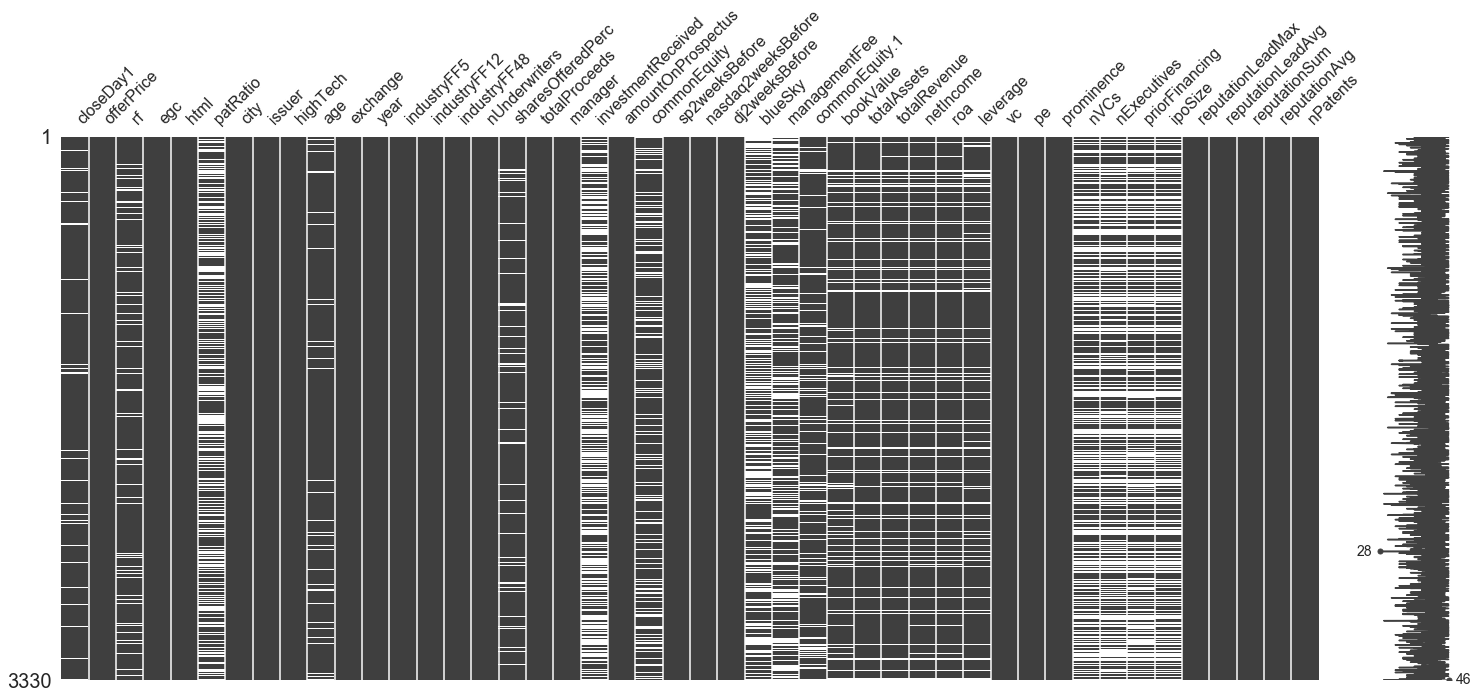

In [20]:
msno.matrix(data)

**Observations** : On this graph we can see that a lot of data are missing, especially in patRatio, investment received, blueSky and nExecutives, priorFinancing, nVCs and ipoSize. For these last four, it seems that data missing correspond to the same rows. It shows that we will need to find a way of filling in the rows.

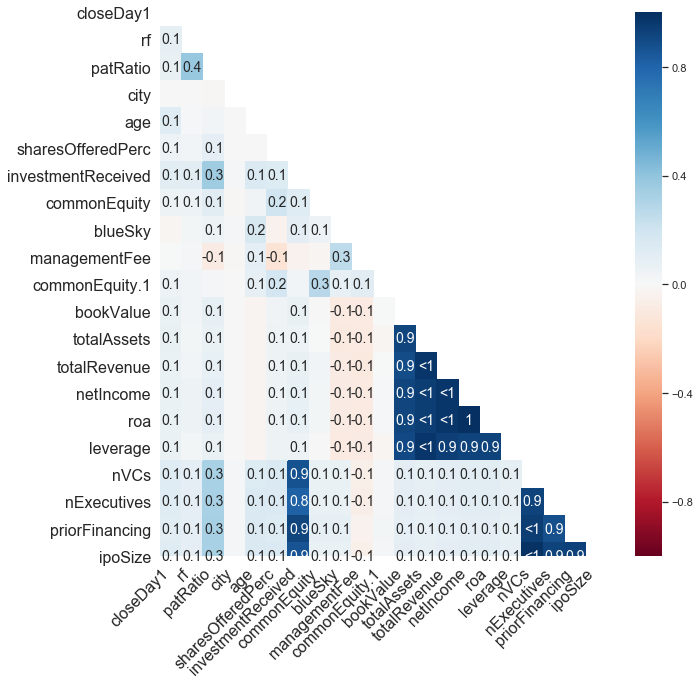

In [21]:
incomplete = data.columns[data.isnull().any()].tolist()
msno.heatmap(data[incomplete], figsize=(10,10))

**Observations**: This map shows the correlation between the missing data. As we may have expected thanks to the previous graph, it seems that nExecutives, priorFinancing and ipoSize missing values are highly correlated. The same phenomenon happens xith totalAssets, totalRevenue, netIncome, roa and leverage.

**Comment**: The following cell shows the correlation among the datafields.

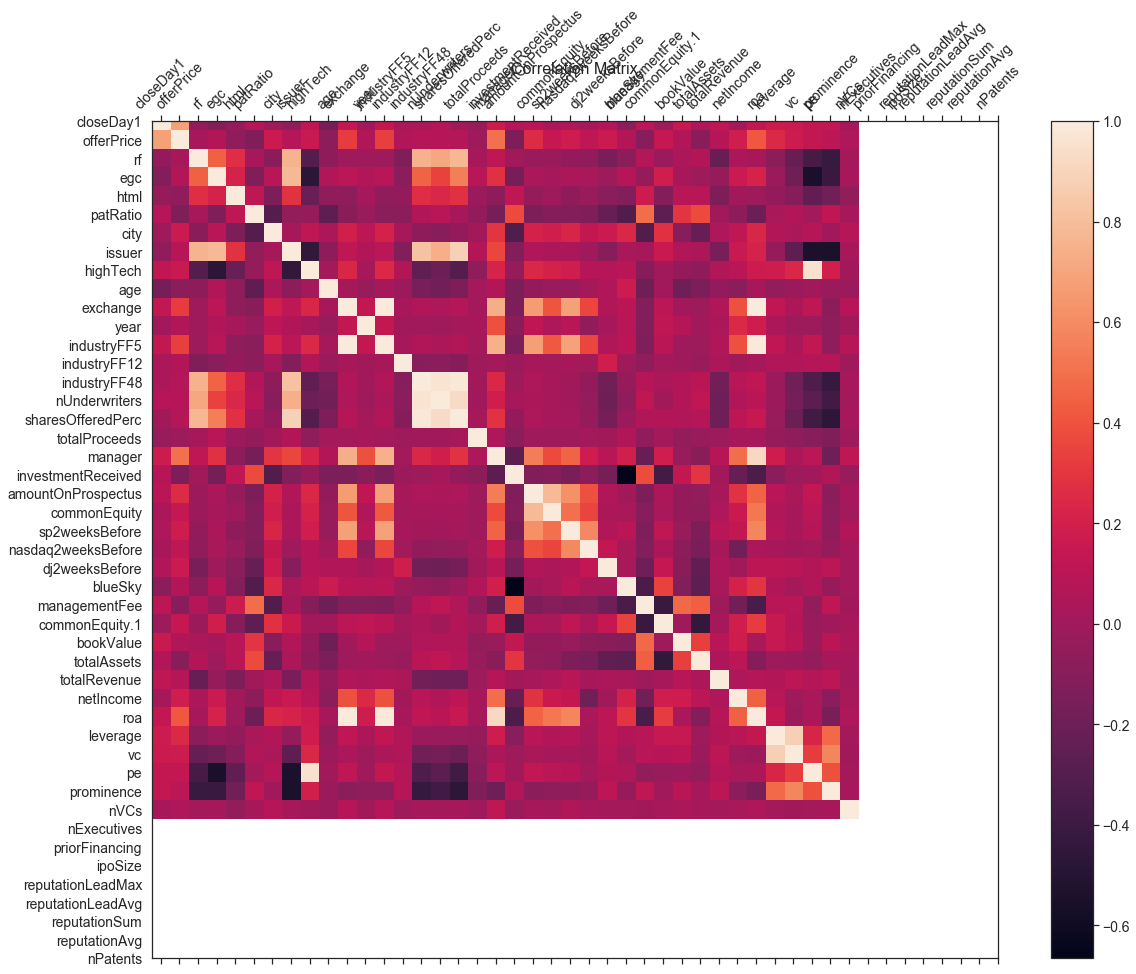

In [22]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

**Observations**: We notice that most of the fields are weakly correlated. However, there are few features that has strong positive and negative correlations.

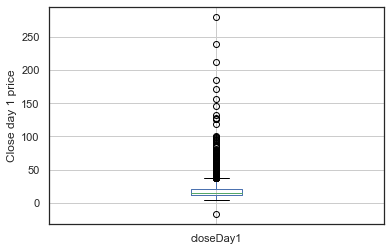

In [23]:
# Distribution of the Close day 1
data.boxplot(column='closeDay1')
plt.ylabel('Close day 1 price')
plt.show()

In [24]:
df_learn['exchange'].value_counts()

NASDQ    2368
NYSE      895
AMEX       67
Name: exchange, dtype: int64

In [25]:
df_learn['industryFF5'].value_counts()

Business Equipment, Telephone and Television Transmission                                         1122
Other                                                                                              898
Healthcare, Medical Equipment, and Drugs                                                           621
Consumer Durables, NonDurables, Wholesale, Retail, and Some Services (Laundries, Repair Shops)     393
Manufacturing, Energy, and Utilities                                                               296
Name: industryFF5, dtype: int64

In [26]:
df_learn['industryFF12'].value_counts().head()

Business Equipment -- Computers, Software, and Electronic Equipment    945
Healthcare, Medical Equipment, and Drugs                               621
Finance                                                                483
Other                                                                  462
Wholesale, Retail, and Some Services (Laundries, Repair Shops)         271
Name: industryFF12, dtype: int64

In [27]:
df_learn['industryFF48'].value_counts().head()

Business Services          845
Pharmaceutical Products    409
Trading                    221
Electronic Equipment       190
Retail                     158
Name: industryFF48, dtype: int64

**Comments**: In order to decrease the number of features, it will probably be necessary to only keep one of the categories between industryFF48, industryFF12 and industryFF5. It will probably be industryFF12 as it seems to be a good trade-off between the accuracy of the data and the number of features.


In [28]:
df_learn = df_learn.rename(columns={"commonEquity":"commonEquity1","commonEquity.1":"commonEquity2" })

**Comments**: Age is the age of the firm. We were wondering if an age of zero means that the firm is brand new. 

In [29]:
print(df_learn['age'].mean())
print(df_learn['age'].mode())

16.184561626429478
0    3.0
dtype: float64


In [30]:
len([w for w in df_learn['age'] if w>100])

53

**Comments**: There is a lot of very old companies.

In [31]:
print(df_learn['blueSky'].median(), df_learn['blueSky'].mean())

10000.0 12916.115884115885


**Comments**: There is a lot of missing values in this feature and the mean and median are relatively differents so we will need to choose by which one we replace the missing values.

# Part 1: data cleaning and preprocessing


In [32]:
processed_data = copy.deepcopy(df_learn)

## Part 1A : Replacing the null fields
**Comment**: In the following cells, we replace or drop the null fields using appropriate logic for that perticular field. We have decided to use the median values when the distributions had some very extreme values, and the mean otherwise.

In [33]:
processed_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [34]:
processed_data['age'].fillna(processed_data['age'].median(), inplace=True)

In [35]:
processed_data['blueSky'].fillna(processed_data['blueSky'].median(), inplace=True)

We decide to drop the data corresponding to missing or negative values of 'closeDay1' as this is a key feature and so replacing missing values may lead to huge misinterpretation. Moreover it corresponds to only 3.5% of the data


In [36]:
processed_data.dropna(subset=["closeDay1"], inplace=True)

**Comment** : We fill the null "Risk factor" field with ""

In [37]:
processed_data.rf.fillna("", inplace=True)

In [38]:
processed_data['patRatio'].fillna(processed_data['patRatio'].median(), inplace=True)

In [39]:
replace_mean = ["sharesOfferedPerc", "investmentReceived", "commonEquity1", "managementFee", "commonEquity2", "bookValue", "totalAssets", "totalRevenue", "netIncome", "roa", "leverage", "priorFinancing", "ipoSize"]

In [40]:
processed_data[replace_mean].head(2)

,sharesOfferedPerc,investmentReceived,commonEquity1,managementFee,commonEquity2,bookValue,totalAssets,totalRevenue,netIncome,roa,leverage,priorFinancing,ipoSize
974,30.50,64190.0,NaN,924417.0,100.00,219.134,240.974,23.34,-48.811,-0.203,0.000,64190.0,6.811e+07
2585,17.09,NaN,0.063,NaN,40.99,231.419,2190.648,142.89,15.918,0.007,0.155,NaN,NaN


In [41]:
processed_data[replace_mean] = processed_data[replace_mean].apply(lambda x: x.fillna(x.mean()),axis=0)

In [42]:
processed_data[replace_mean].head(2)

,sharesOfferedPerc,investmentReceived,commonEquity1,managementFee,commonEquity2,bookValue,totalAssets,totalRevenue,netIncome,roa,leverage,priorFinancing,ipoSize
974,30.50,64190.000,-0.880,9.244e+05,100.00,219.134,240.974,23.34,-48.811,-0.203,0.000,64190.000,6.811e+07
2585,17.09,172172.815,0.063,2.070e+06,40.99,231.419,2190.648,142.89,15.918,0.007,0.155,130854.105,1.454e+08


In [43]:
replace_median = ["nExecutives", "nVCs"]

In [44]:
processed_data[replace_median].head(2)

,nExecutives,nVCs
974,5.0,5.0
2585,NaN,NaN


In [45]:
processed_data[replace_median] = processed_data[replace_median].apply(lambda x: x.fillna(x.median()),axis=0)

In [46]:
processed_data[replace_median].head(2)

,nExecutives,nVCs
974,5.0,5.0
2585,11.0,6.0


In [47]:
processed_data.shape

(3215, 46)

In [ ]:
#data.profile_report()


Referring to the profile report generated, attached as HTML along with submission.

We can see that some features are highly correlated, so we will use PCA to remove the redundant features.

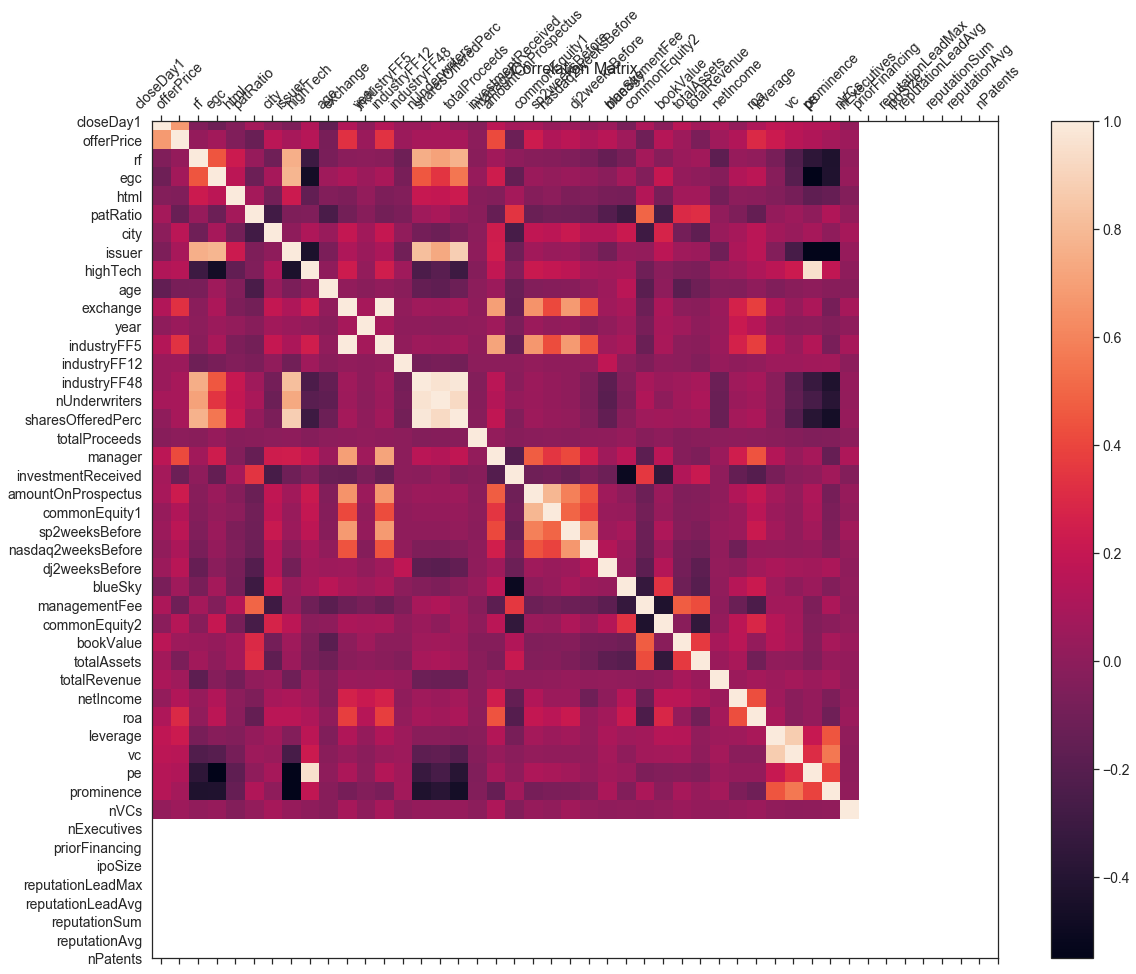

In [48]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(processed_data.corr(), fignum=f.number)
plt.xticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14, rotation=45)
plt.yticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

The following cell shows that all the filed are pre-processed since there is no null fields anymore. We can also notice that the number of rows have reduced, which was expected as we have decided to drop the lines with emply CloseDay1.

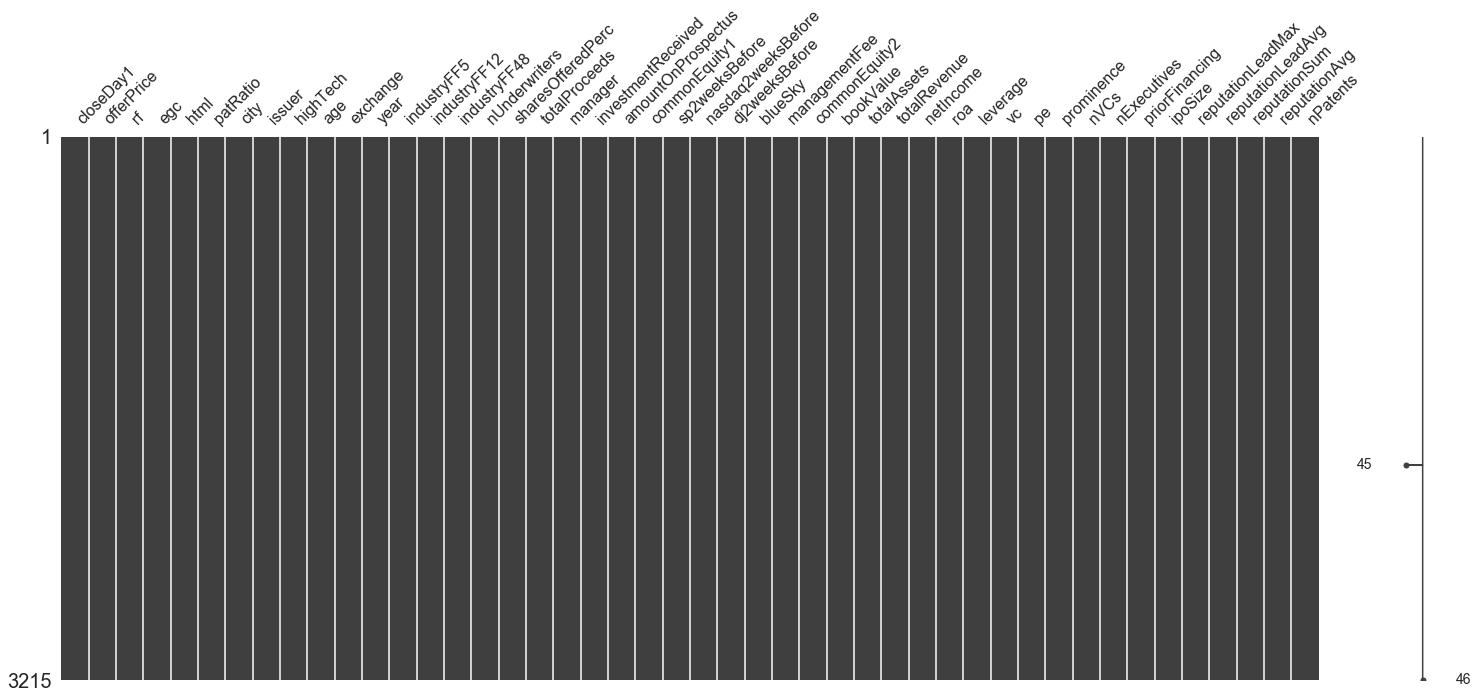

In [49]:
msno.matrix(processed_data)

## Part 1B: Manipulating the fields (Addition, deletion)

**Comments**

1. 'issuer' is unique, hence it will not be a useful feature for prediction. We drop it from the list of useful features and set it as index.
2. 'Exchange' is categorical (3 distinct values) so we create dummies
3. 'IndustryFF12' is also categorical (12 distinct values) and we will use dummies variables to deal with it. 
4. ['manager', 'city'] have high cardinality, hence dropped from the useful features
5. Update True/False fields to 1/0

In [50]:
# Unique field 'issuer' is made index of the cell
processed_data.set_index('issuer', drop=True, inplace=True)

In [51]:
processed_data = pd.get_dummies(data=processed_data, columns= ['exchange', 'industryFF12'])

In [52]:
processed_data.drop(['manager', 'city'], axis=1, inplace=True)

In [53]:
# Creating additional field for return and raisingPrice(upORdown)
processed_data['return'] = (processed_data['closeDay1'] - processed_data['offerPrice'])/(processed_data['offerPrice'] + 1e-10)
processed_data["raisingPrice"] = (processed_data["return"] > 0).astype(int)

Converting all boolean fields to int type (0-False or 1-True)

In [54]:
processed_data[processed_data.select_dtypes([np.bool]).columns] = processed_data.select_dtypes([np.bool]).astype(int)

In [55]:
processed_data['raisingPrice'].shape

(3215,)

In [56]:
processed_data.info(verbose=False, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3215 entries, Numerical Technologies Inc to Threshold Pharmaceuticals Inc
Columns: 58 entries, closeDay1 to raisingPrice
dtypes: float64(29), int64(11), object(3), uint8(15)
memory usage: 1.1+ MB


In [57]:
#processed_data = processed_data.head(200)

## Part 1C: Text pre-process on Risk Factor

**Comments**
The risk-factor features corresponds to an 'essay' explaining the risk factors for each investment. In order to be able to use it, we will pre-process the text to extract the main information and then use LDA on it.

In [58]:
# Get English Stopwords from NLTK & Extend the stop word list
stop_words = stopwords.words('english')
stop_words.extend(['risk', 'factor', 'company', 'stock', 'may', 'inc', 'co', 'result', 'financial', \
               'portfolio', 'business', 'market', 'customer', 'service', 'price', 'management', \
              'product', 'operation', 'adversely', 'new', 'revenue', 'sale', 'operating', \
                   'adverse', 'effect', 'consider', 'careful', 'need', 'cost', 'information', 'investment', \
                   'fact', 'carefully', 'following', 'common', 'could'
              ])


**Comments**:  To the list of stop-words we have added words that came back in every text and added no information.

In [59]:
print(len(stop_words), stop_words[:10])
''.join(stop_words).__contains__('could')

215 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


True

In [60]:
#looks how many percent of risk facor are NaN values
processed_data['rf'].isna().sum()/len(processed_data['rf'])

0.0

In [61]:
#file them with a blank
processed_data['rf'] = processed_data['rf'].fillna('')

We start by removing all the ponctuation in order to only keep words and numbers.

In [62]:
# Define a custom function to clean some given text
def clean_re(txt):
    txt = re.sub(f"[{string.punctuation}]", "", str(txt))
    
    return txt

In [63]:
# Test clean_re
txt = "akjdf!!@#$%^&*()_/*965214"
clean_re(txt)

'akjdf965214'

In [64]:
# Apply clean_re() to all features
processed_data['rf'] = processed_data['rf'].apply(clean_re)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       RISK FACTORS You should carefully consider the...
Home BancShares Inc,Conway,AR    risk factors an investment in our common stock...
Name: rf, dtype: object

We have decided to lemmatize the text before removing stop-words, so we get the root of each word and can remove them even if they are plurarls or in conjugated form.

In [65]:
wnl=nltk.stem.WordNetLemmatizer()

def lemmatize_text(txt):
    return ' '.join([wnl.lemmatize(t.lower()) for t in txt.split(' ')])

In [66]:
# Apply lemmatize_text() to all features  
processed_data['rf'] = processed_data['rf'].apply(lemmatize_text)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       risk factor you should carefully consider the ...
Home BancShares Inc,Conway,AR    risk factor an investment in our common stock ...
Name: rf, dtype: object

**Comment**: We notice tht the wordnetlimmatizer doesn't process words such as carefully -> careful. We were wondering about using other nltk tools such as the  ones shown below. However, the Lancaster Stemmer process words beyond recognition such as carefully-> car, so we decided to go ahead without further processing.

In [67]:
#lnl=nltk.stem.LancasterStemmer()

#def lemmatize_text_lnl(txt):
#    return ' '.join([lnl.stem(t.lower()) for t in txt.split(' ')])

In [68]:
# Apply lemmatize_text() to all features  
#processed_data['rf'] = processed_data['rf'].apply(lemmatize_text_lnl)    
#processed_data['rf'].head(2)

In [69]:
# Define custom function to remove stopwords
def clean_stopwords(txt):
    li = list(txt.lower().split(" "))
    txt = [word for word in li if word not in stop_words]
    return ' '.join(txt)

#pattern = re.compile(r'(?i)\b(' + r'|'.join(stop_words) + r')\b\s*')
#def clean_stopwords(txt):
#    txt = pattern.sub('', txt)
#    return txt 

In [70]:
# Test clean_stopwords
txt = " ".join(stop_words).lower()
print("**All stop words**:", txt)
print("Cleaned text : ", clean_stopwords(txt))

**All stop words**: i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't risk factor company stock may inc co result 

In [71]:
# Apply function to remove stopwords
processed_data['rf'] = processed_data['rf'].apply(clean_stopwords)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       contained prospectus purchasing key within sem...
Home BancShares Inc,Conway,AR    involves making decision described together co...
Name: rf, dtype: object

In [72]:
# Define custom function to wrap simple_preprocess() from gensim
#def sp(txt):
#    return simple_preprocess(txt)

# Define custom function to wrap simple_preprocess() from gensim
def wrap_simple_preprocess(txt):
    return simple_preprocess(str(txt))

In [73]:
# Apply simple_preprocess() to all features
processed_data['rf'] = processed_data['rf'].apply(wrap_simple_preprocess)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       [contained, prospectus, purchasing, key, withi...
Home BancShares Inc,Conway,AR    [involves, making, decision, described, togeth...
Name: rf, dtype: object

# Part 2: Feature extraction

The goal is to extract features from the processed data and use them for training the models.

## Part 2A: Extracting features from 'rf'

In this section, we utilize NLP to process risk factors and extract useful features for prediction.
Reference: [web link](https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html)

### Topic models

We try various topic models (LSI, HDA, LDA) and select one of them based on the coherence score.

In [74]:
id2word = corpora.Dictionary(processed_data['rf'])
corpus = [id2word.doc2bow(doc) for doc in processed_data['rf']]

**Comment**: We create a LDA model with initial number of topics, to check if it works before tuning the hyperparameter num_topics

In [75]:
no_topics = 4
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word, num_topics=no_topics, random_state=SEED,
)

**Comment**: Check coherence score metric

In [76]:
cm_lda = CoherenceModel(model=lda_model, texts=processed_data["rf"], dictionary=id2word)
print(f"Coherence score : {cm_lda.get_coherence():.3f}")
coherence_values = [(cm_lda, no_topics)]

Coherence score : 0.261


**Comment**: Hyper parameter selection for the LDA model based on coherence score

In [77]:
lda_models, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=processed_data.rf, start=1, limit=15, step=1)

In [78]:
coherence_values = np.array(coherence_values)

In [79]:
index_selected = np.argmax(coherence_values[:,0])
no_topics_selected = no_topics(coherence_values[index_selected,1])
no_topics_selected

4

In [80]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word, num_topics=no_topics_selected, alpha='auto', eta='auto', random_state=SEED,
)

In [81]:
# Visualize topics-keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

Creating other NLP models to process 'risk factor' text

In [82]:
lsi_model = LsiModel(corpus=corpus, num_topics=no_topics_selected, id2word=id2word)

In [83]:
hdp_model = HdpModel(corpus=corpus, id2word=id2word)

In [84]:
texts = processed_data.rf
lda_coherence = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word).get_coherence()
lsi_coherence = CoherenceModel(model=lsi_model, texts=texts, dictionary=id2word).get_coherence()
hdp_coherence = CoherenceModel(model=hdp_model, texts=texts, dictionary=id2word).get_coherence()

In [85]:
df_coherence = pd.DataFrame({'LDA':[lda_coherence], 'LSI':[lsi_coherence], 'HDP':[hdp_coherence]}, index=['Coherence score'])
df_coherence.T.plot.bar()
plt.ylabel("Coherence score")
df_coherence

**Comment** : We notice that LSI, LDA and HDP models have different coherence score. We observe that HDP has highest score. We select LDA because the number of selected topics is smaller and the topic seems more intuitive.

In [86]:
# Visualize topics-keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(hdp_model, corpus, id2word)
vis

### Extracting feature vector for each observation

In [87]:
#selected_rf_model = hdp_model.suggested_lda_model()
selected_topic_model = lda_model

In [88]:
rows = processed_data.rf.shape[0]
rows

3215

In [89]:
features_rf = []
for i in range(rows):
    top_topics = selected_topic_model.get_document_topics(corpus[i], minimum_probability=0.0)
    #top_topics = hdp_model.evaluate_test_corpus([corpus[i]])
    topic_vec = [top_topics[i][1] for i in range(int(no_topics_selected))]
    #topic_vec.extend([len(processed_data["rf"].iloc[i])])
    #topic_vec.extend([len(''.join(processed_data["rf"].iloc[i]))]) # length review
    features_rf.append(topic_vec)

In [90]:
df_rf_features = pd.DataFrame(features_rf, columns=range(int(no_topics_selected)), index=processed_data.rf.index).add_prefix('rf_')
pd.concat([df_rf_features, df_rf_features.sum(axis=1)], axis=1).head(3)

,rf_0,rf_1,rf_2,rf_3,0
issuer,,,,,
Numerical Technologies Inc,0.817,6.847e-04,0.162,2.000e-02,1.0
"Home BancShares Inc,Conway,AR",0.029,9.590e-01,0.011,7.200e-04,1.0
Boise Cascade Co,0.388,2.080e-01,0.373,3.167e-02,1.0


**Comments**: the value associated with each rf_i correponds to the probability for each text to be related with the corresponding topic. The column 0 shows that the sum of this 4 probabilities is 1.

In [91]:
#lsi_model = LsiModel(corpus=corpus, num_topics=25, id2word=id2word)
#lsi_model.show_topics(num_topics=3)

In [92]:
#lsi_topics = lsi_model.show_topics(formatted=False)

## Part 2B: Feature selection from processed_data

Extract features and targets from the processed_data

In [93]:
# Select targets 
y_data_labels = ['closeDay1', 'return', 'raisingPrice']
Y_data = processed_data[y_data_labels]

X_data = processed_data.drop(y_data_labels, axis=1)
Y_data.columns, X_data.columns

(Index(['closeDay1', 'return', 'raisingPrice'], dtype='object'),
 Index(['offerPrice', 'rf', 'egc', 'html', 'patRatio', 'highTech', 'age',
        'year', 'industryFF5', 'industryFF48', 'nUnderwriters',
        'sharesOfferedPerc', 'totalProceeds', 'investmentReceived',
        'amountOnProspectus', 'commonEquity1', 'sp2weeksBefore',
        'nasdaq2weeksBefore', 'dj2weeksBefore', 'blueSky', 'managementFee',
        'commonEquity2', 'bookValue', 'totalAssets', 'totalRevenue',
        'netIncome', 'roa', 'leverage', 'vc', 'pe', 'prominence', 'nVCs',
        'nExecutives', 'priorFinancing', 'ipoSize', 'reputationLeadMax',
        'reputationLeadAvg', 'reputationSum', 'reputationAvg', 'nPatents',
        'exchange_AMEX', 'exchange_NASDQ', 'exchange_NYSE',
        'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
        'industryFF12_Chemicals and Allied Products',
        'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
  

In [94]:
Y_data.head(3)

,closeDay1,return,raisingPrice
issuer,,,
Numerical Technologies Inc,35.562,1.540,1
"Home BancShares Inc,Conway,AR",20.000,0.111,1
Boise Cascade Co,26.150,0.245,1


We drop the text fields 'rf', 'industryFF12', 'industryFF48' and replace them the extracted features using text analysis for 'rf'

In [95]:
X_data.drop(['rf', 'industryFF5', 'industryFF48'], axis=1, inplace=True)

In [96]:
X = pd.concat([X_data, df_rf_features], axis=1, sort=False)

In [97]:
X.head(2)

,offerPrice,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,...,"industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,industryFF12_Telephone and Television Transmission,industryFF12_Utilities,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,14.0,0,0,0.492,1,5.0,2000,14,30.50,68114956,...,0,0,0,0,0,0,0.817,6.847e-04,0.162,2.000e-02
"Home BancShares Inc,Conway,AR",18.0,0,1,0.448,0,8.0,2006,4,17.09,45000000,...,0,0,0,0,0,0,0.029,9.590e-01,0.011,7.200e-04


In [98]:
X_data.head(2)

,offerPrice,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,...,"industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances","industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys",industryFF12_Finance,"industryFF12_Healthcare, Medical Equipment, and Drugs","industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,industryFF12_Telephone and Television Transmission,industryFF12_Utilities,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)"
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,14.0,0,0,0.492,1,5.0,2000,14,30.50,68114956,...,0,0,0,0,0,0,0,0,0,0
"Home BancShares Inc,Conway,AR",18.0,0,1,0.448,0,8.0,2006,4,17.09,45000000,...,0,0,1,0,0,0,0,0,0,0


### Feature selection for various predictors (P1 o P9)

**Comment**: For each of the predictions we need to do, we create a set with the features used, one with the variable to predict, and finally we draw the distribution for each target variable in order to have an idea of the distribution of prediction we are supposed to get.

**Comment**: Select features for Prediction 1 and look at the target variable distribution

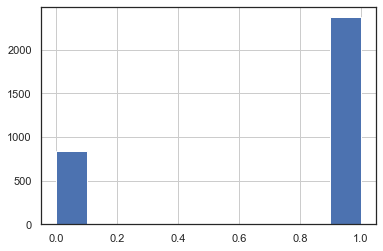

In [99]:
# X_data has all features except 'rf'
X_P1, y_P1 = X_data, Y_data.raisingPrice
assert(X_P1.shape[0] == y_P1.shape[0])
y_P1.hist()

**Comment**: Select features for Prediction 2 and look at the target variable distribution

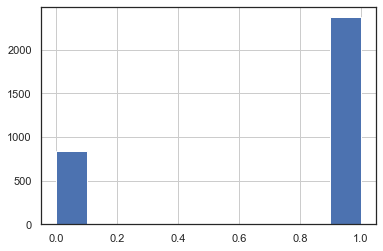

In [100]:
# Data frame X contains all numeric features including extracted features from 'rf'
X_P2, y_P2 = X.filter(regex=("(rf_*)|(FF12_*)|(year)")), Y_data.raisingPrice
assert(X_P2.shape[0] == y_P2.shape[0])
y_P2.hist()

**Comment**: Select features for Prediction 3 and look at the target variable distribution. We select all the available features for predictions from P3 to P9, reduce the dimention using PCA so that features that are not relevent are filtered.

((3215, 56), <matplotlib.axes._subplots.AxesSubplot at 0x7f213b5b1fd0>)

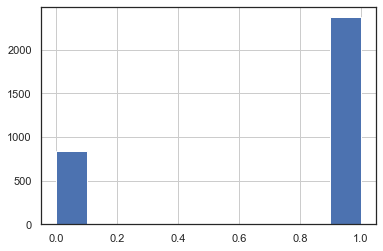

In [101]:
y_P3 = Y_data.raisingPrice
assert(X.shape[0] == y_P3.shape[0])
X.shape, y_P3.hist()

**Comment**: Target variable 'return' distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f213b5b19e8>]],
      dtype=object)

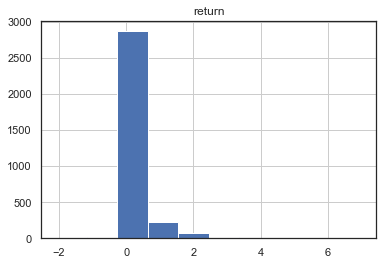

In [102]:
Y_data['return'].reset_index().hist()

**Comment**: Select features for Prediction 4 and look at the target variable distribution

((3215, 56), <matplotlib.axes._subplots.AxesSubplot at 0x7f213ba90c88>)

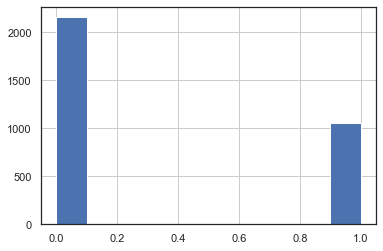

In [103]:
y_P4 = (Y_data['return'] > 0.20).astype('int')
assert(X.shape[0] == y_P4.shape[0])
X.shape, y_P4.hist()

**Comment**: Select features for Prediction 5 and look at the target variable distribution

((3215, 56), <matplotlib.axes._subplots.AxesSubplot at 0x7f213ba639b0>)

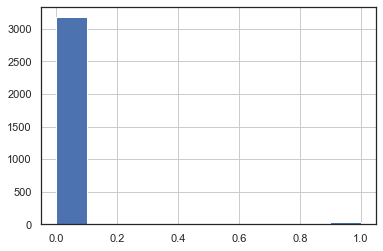

In [104]:
y_P5 = (Y_data['return'] < -0.20).astype('int')
assert(X.shape[0] == y_P5.shape[0])
X.shape, y_P5.hist()

**Comment**: Select features for Prediction 6 and look at the target variable distribution

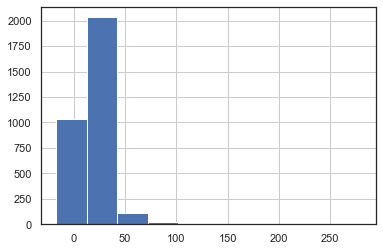

In [105]:
y_P6 = Y_data['closeDay1']
assert(X.shape[0] == y_P6.shape[0])
y_P6.hist()

**Comment**: Select features for Prediction 7 and look at the target variable distribution

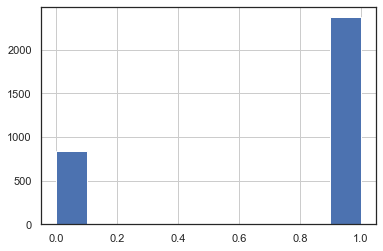

In [106]:
y_P7 = Y_data.raisingPrice
assert(X.shape[0] == y_P7.shape[0])
y_P7.hist()

**Comment**: Select features for Prediction 8 and look at the target variable distribution

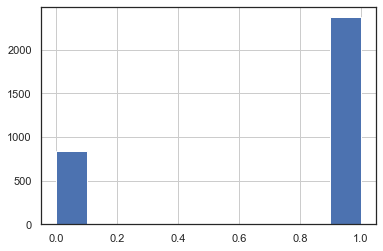

In [107]:
y_P8 = Y_data.raisingPrice
assert(X.shape[0] == y_P8.shape[0])
y_P8.hist()

**Comment**: Select features for Prediction 9 and look at the target variable distribution

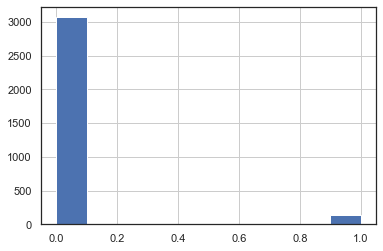

In [108]:
y_P9 = (Y_data['return'] < -0.10).astype('int')
assert(X.shape[0] == y_P9.shape[0])
y_P9.hist()

# Part 3: Feature reduction

We will reduce features using PCA and  select numeric fields for PCA.

In [109]:
# Select features for PCA
data_pca = X.select_dtypes([np.number])
max_components = len(data_pca.columns)

In [110]:
data_pca.head(2)

,offerPrice,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,...,"industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,industryFF12_Telephone and Television Transmission,industryFF12_Utilities,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,14.0,0,0,0.492,1,5.0,2000,14,30.50,68114956,...,0,0,0,0,0,0,0.817,6.847e-04,0.162,2.000e-02
"Home BancShares Inc,Conway,AR",18.0,0,1,0.448,0,8.0,2006,4,17.09,45000000,...,0,0,0,0,0,0,0.029,9.590e-01,0.011,7.200e-04


In [111]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P1, y_P1, test_size=0.2,  random_state=SEED)

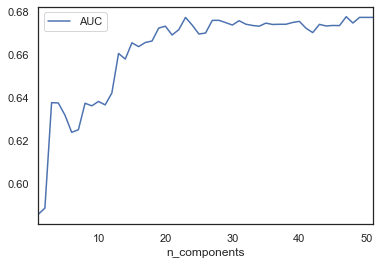

In [112]:
# Explore and print out results for the relationship between AUC and the number of PCA Component Features
estimators = []
estimators.append(('standardize', StandardScaler()))
pca = PCA()
estimators.append(('pca', pca))
estimators.append(('model', LogisticRegression()))
pipeline = Pipeline(estimators)
max_components = X_train.shape[1]
results = []
for c in range(1,max_components):
    pipeline.set_params(pca__n_components=c)
    pipeline.fit(X_train,y_train)
    y_train_pred = pipeline.predict_proba(X_test)       # use validation set during hyper-parameter tuning
    auc_lml1 = roc_auc_score(y_test, y_train_pred[:,1])   
    results.append( (auc_lml1, c)  )

df_auc_vs_pca = pd.DataFrame(results, columns=['AUC', 'n_components'])

df_auc_vs_pca.plot('n_components', 'AUC')
plt.savefig('pca_n_components.png')

In [113]:
explained_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), index=range(1,max_components), columns=['Cummulative explained variance'])
explained_variance.head(10)

,Cummulative explained variance
1,0.128
2,0.243
3,0.315
4,0.364
5,0.401
6,0.433
7,0.462
8,0.489
9,0.514
10,0.537


Search for optimum PCA components using the cross validation approach.

### PCA for P1 prediction features

In [114]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P1, y_P1, test_size=0.2,  random_state=SEED)

In [115]:
param_grid = {
    'pca__n_components': range(1, max_components),
    'model__C': range(1, 10),
}
# Select cross validation scheme
cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=SEED)
search = GridSearchCV(pipeline, param_grid, iid=False, cv=cv)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
pca = search.best_estimator_.get_params()['pca']
P1_n_components = pca.n_components

Best parameter (CV score=0.749):
{'model__C': 4, 'pca__n_components': 26}


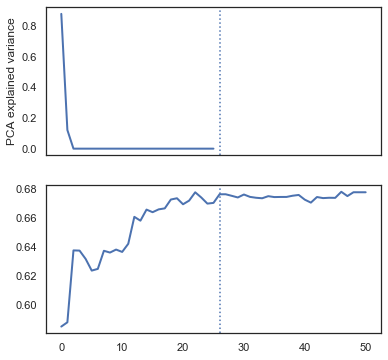

In [116]:
# Plot the PCA spectrum
pca.fit(X_train)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')

ax1.plot(df_auc_vs_pca.AUC, linewidth=2)
ax1.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.savefig('pca_explained_variance.png')

For prediction 1, the optimal number of components is 26.

### PCA for P2 prediction features

In [117]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P2, y_P2, test_size=0.2,  random_state=SEED)

In [118]:
max_components = X_train.shape[1]
param_grid = {
    'pca__n_components': range(1, max_components),
    'model__C': range(1, 10),
}
# Select cross validation scheme
cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=SEED)
search = GridSearchCV(pipeline, param_grid, iid=False, cv=cv)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
pca = search.best_estimator_.get_params()['pca']

Best parameter (CV score=0.741):
{'model__C': 1, 'pca__n_components': 1}


In [119]:
P2_n_components = 20

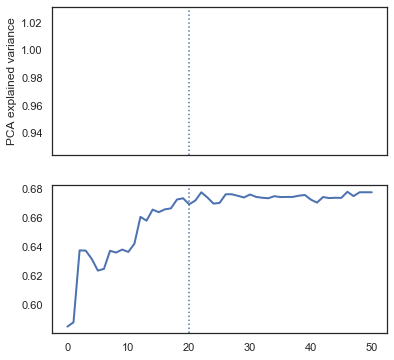

In [120]:
# Plot the PCA spectrum
pca.fit(X_train)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(P2_n_components,
            linestyle=':', label='n_components chosen')

ax1.plot(df_auc_vs_pca.AUC, linewidth=2)
ax1.axvline(P2_n_components,
            linestyle=':', label='n_components chosen')
plt.savefig('pca_explained_variance.png')

For prediction 2, the optimal number of components is min(17, 20) = 17 so all the features, because there is no tims constraints). But with only 1 components the results are already good enough.

### PCA for P3 prediction features

In [121]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [122]:
max_components = X_train.shape[1]
param_grid = {
    'pca__n_components': range(1, max_components),
    'model__C': range(1, 10),
}
# Select cross validation scheme
cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=SEED)
search = GridSearchCV(pipeline, param_grid, iid=False, cv=cv)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
pca = search.best_estimator_.get_params()['pca']
P3_n_components = pca.n_components

Best parameter (CV score=0.750):
{'model__C': 6, 'pca__n_components': 22}


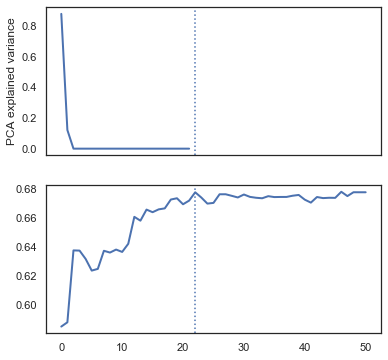

In [123]:
# Plot the PCA spectrum
pca.fit(X_train)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')

ax1.plot(df_auc_vs_pca.AUC, linewidth=2)
ax1.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.savefig('pca_explained_variance.png')

For prediction P3, if we the optimal number of components is 22.

# Part 4: Training, tuning, and testing of each model

### Steps in training the model and selection of best hyper parameters
0. Split the dataset into traing and testing sets
1. Create pipeline for the respective model
2. Select parameters grid for the respective model
3. Create cross validation scheme
4. Search for the best estimator using Grid search on the train dataset
5. Find the best estimator for given feature and target set using the train dataset
6. Test the best estimator performance using test dataset

**Manual cross check of the best estimator**: We evaluate the model obtained from gridSearch manually and verify the performance before using it for the predictions in Part-5.

In [124]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

## 0. Random guessing model

In [438]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # standardize features
estimators.append(('model', DummyClassifier(strategy='constant', constant=np.random.choice([0, 1]), random_state=SEED)))
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
random_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


In [126]:
random_model_final = custom_train_test_function(random_model, X_train, y_train, name="Random model", plot_train_score=False)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.500):
{}


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


### Steps involved in training the model

In [127]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [128]:
y_hat_random = [np.random.choice([0, 1]) for v in y_test]
pd.Series(y_hat_random).value_counts()

1    329
0    314
dtype: int64

### Test the model (AUC, ROC....etc)

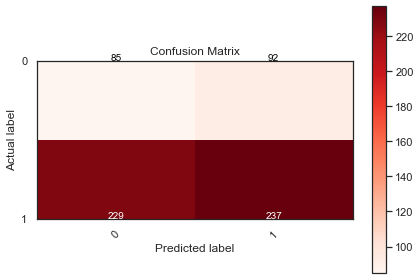

In [129]:
cm_random = confusion_matrix(y_test, y_hat_random)  
plot_confusion_matrix(cm_random)

In [130]:
# Calculate accuracy
accuracy_random = 1 - ((cm_random[0][1] + cm_random[1][0])/(cm_random[0][1] + cm_random[1][0] + cm_random[1][1] + cm_random[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_random))

Accuracy   = 0.5008


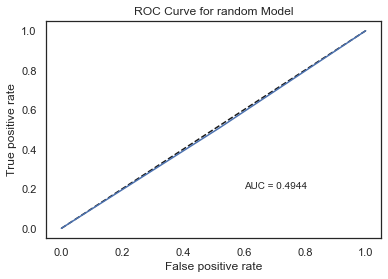

In [131]:
#plot roc curve
fpr_logit_random, tpr_logit_random, _ = roc_curve(y_test, y_hat_random)
best_auc_random = roc_auc_score(y_test, y_hat_random)
plot_roc(fpr_logit_random, tpr_logit_random, 'ROC Curve for random Model', 'AUC = %2.4f' % best_auc_random)

## A. Baseline model

In [132]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [439]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', DummyClassifier(strategy='most_frequent', random_state=SEED)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
baseline_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

In [134]:
baseline_model_final = custom_train_test_function(baseline_model, X_train, y_train, name="Baseline model")

===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.500):
{}


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


### Select data

In [135]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [136]:
#Look at the most commonly predicted outcome
most_frequent_outcome = Y_data['raisingPrice'].value_counts().idxmax()
print('Most frequent outcome =', most_frequent_outcome)

Most frequent outcome = 1


### Train the model

In [137]:
y_hat_baseline = [most_frequent_outcome ]*len(y_test)
pd.Series(y_hat_baseline).value_counts()

1    643
dtype: int64

### Test the model (AUC, ROC....etc)

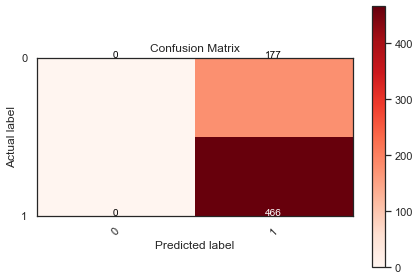

In [138]:
cm_baseline = confusion_matrix(y_test, y_hat_baseline)  
plot_confusion_matrix(cm_baseline)

In [139]:
# Calculate accuracy
accuracy_baseline = 1 - ((cm_baseline[0][1] + cm_baseline[1][0])/(cm_baseline[0][1] + cm_baseline[1][0] + cm_baseline[1][1] + cm_baseline[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_baseline))

Accuracy   = 0.7247


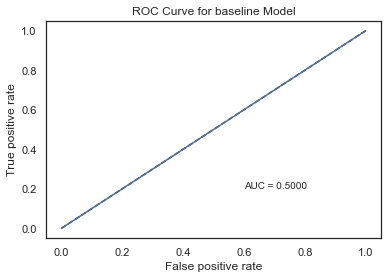

In [140]:
#plot roc curve
fpr_logit_baseline, tpr_logit_baseline, _ = roc_curve(y_test, y_hat_baseline)
best_auc_baseline = roc_auc_score(y_test, y_hat_baseline)
plot_roc(fpr_logit_baseline, tpr_logit_baseline, 'ROC Curve for baseline Model', 'AUC = %2.4f' % best_auc_baseline)

**Comments**:  obviously, we don't expect the random and baseline model to get goood values for accuracy and AUC but we will use them later in order to compare the values of "better" models and define if they are acceptable or no.

## B. Linear model

In [219]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [440]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', LinearRegression(fit_intercept=False, n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
linear_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

In [221]:
linear_model_final = custom_train_test_function(linear_model, X_train, y_train, name="Linear model", test_req=True, custom_test=True)

===============... Training the Linear model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.665):
{}


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


### B1 : Linear model without 'risk factor'

In [144]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [145]:
ols_model_p1 = LinearRegression(normalize=True, n_jobs=-1)

### Train the model

In [146]:
ols_model_p1.fit(X_train, y_train)
y_hat_ols_prob = ols_model_p1.predict(X_train_val)

### Validation and hyper parameter tuning

In [147]:
results = []
for i in range(1, 100):
    threshold = 0.01 * i
    y_hats   = [int(v >= threshold) for v in y_hat_ols_prob]
    correct  = [int(r[0]==r[1]) for r in zip(y_train_val, y_hats)]
    accuracy = sum(correct)/len(correct)
    results.append( (accuracy, threshold) )
optimal_p = sorted(results, reverse=True)[0][1]
print('Optimal probability threshold based on accuracy = %2.4f' % optimal_p, 'and the corresponding accuracy is ', sorted(results, reverse=True)[0][0])

Optimal probability threshold based on accuracy = 0.5900 and the corresponding accuracy is  0.7698289269051322


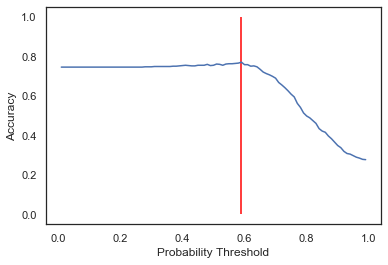

In [148]:
y,x = zip(*results)
plt.plot(x, y)
plt.vlines(optimal_p, ymin=0, ymax=1, colors=['red'])
plt.ylabel('Accuracy')
plt.xlabel('Probability Threshold')
plt.show()

**Comments**: here the threshold corresponding to the best accuracy is 0.59 with an accuracy higher thn the baseline one.

### Test the model (AUC, ROC....etc)

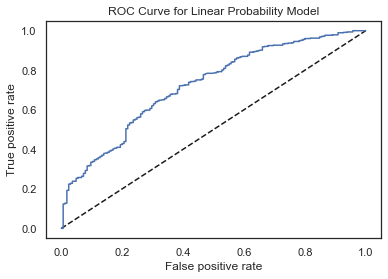

In [149]:
fpr_ols, tpr_ols, _ = roc_curve(y_train_val, y_hat_ols_prob)
auc_ols = roc_auc_score(y_train_val, y_hat_ols_prob)
plot_roc(fpr_ols, tpr_ols, 'ROC Curve for Linear Probability Model')

In [150]:
y_hat_ols_prob_test = ols_model_p1.predict(X_test)
y_hats   = [int(v >= optimal_p) for v in y_hat_ols_prob_test]

In [151]:
auc_ols = roc_auc_score(y_test, y_hats)
print('AUC for linear probability model = %2.4f' % auc_ols)

AUC for linear probability model = 0.5509


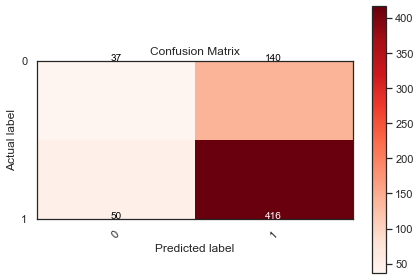

In [152]:
cm_baseline = confusion_matrix(y_test, y_hats)  
plot_confusion_matrix(cm_baseline)

In [153]:
# Calculate accuracy
accuracy_baseline = 1 - ((cm_baseline[0][1] + cm_baseline[1][0])/(cm_baseline[0][1] + cm_baseline[1][0] + cm_baseline[1][1] + cm_baseline[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_baseline))

Accuracy   = 0.7045


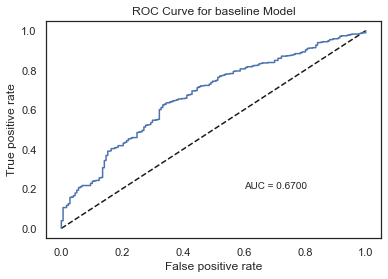

In [154]:
#plot roc curve
fpr_logit_baseline, tpr_logit_baseline, _ = roc_curve(y_test, y_hat_ols_prob_test)
best_auc_baseline = roc_auc_score(y_test, y_hat_ols_prob_test)
plot_roc(fpr_logit_baseline, tpr_logit_baseline, 'ROC Curve for baseline Model', 'AUC = %2.4f' % best_auc_baseline)

### Comments 

The AUC is above the baseline one, as we could have expected. The accuracy is also better than the baseline one. So this model is probably too simple to get very good results but is not so bad.

We can further train the linear probability model for all other predictors (P2 to P9) and select a best estimator for each accordingly. We decided to do this using a custom train_test_function_declared in the beginning. The best fit model for Prediction P2 is given below.

In [155]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P2, y_P2, test_size=0.2,  random_state=SEED)

In [156]:
linear_model_final_P2 = custom_train_test_function(linear_model, X_train, y_train, name="Linear model", test_req=False, custom_test=True)

===============... Training the Linear model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.582):
{}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


## C. Logit model

## C.1 : with L1 regulation

In [157]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [441]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', LogisticRegression(penalty='l1', n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__C' : np.logspace(-4, 5, 10),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logit_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.685):
{'model__C': 0.1}

===============Training results with cross validation...===============



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.0s finished


,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,0.685,0.013,1,0.721,0.006
4,0.675,0.015,2,0.729,0.004
5,0.673,0.013,3,0.729,0.004
6,0.672,0.013,4,0.729,0.004
7,0.672,0.013,5,0.729,0.004
9,0.672,0.013,6,0.729,0.004
8,0.672,0.013,7,0.729,0.004
2,0.612,0.008,8,0.629,0.007
0,0.500,0.000,9,0.500,0.000
1,0.500,0.000,9,0.500,0.000


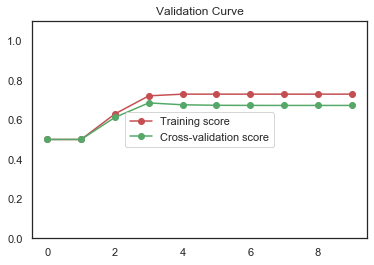

In [159]:
logit_model_final = custom_train_test_function(logit_model, X_train, y_train, name="Logit model", proba=True, plot_train_score=True)


In [160]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [161]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('logit_model_l1', LogisticRegression()))  # tell it to use a logit model
pipeline = Pipeline(estimators) 
pipeline.set_params(logit_model_l1__penalty='l1') 

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit_model_l1', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

###  Hyper parameter tuning

In [162]:
# Tune C  
results = []
for c in np.logspace(-4, 5, 10):
    pipeline.set_params(logit_model_l1__C=c) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_lml1 = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append( (auc_lml1, c)  )
logit_model_l1 = pipeline.named_steps['logit_model_l1']      # capture model so we can use it later

In [163]:
# View results 
print('C'.center(12), '   ', 'AUC'.center(8), '\n', '=' * 25)
for (auc, c) in results:
    print('{0:.4f}'.format(c).rjust(12), '   ',  '{0:.4f}'.format(auc).center(8))

     C             AUC    
      0.0001      0.5000 
      0.0010      0.5000 
      0.0100      0.6968 
      0.1000      0.7022 
      1.0000      0.7014 
     10.0000      0.7031 
    100.0000      0.7029 
   1000.0000      0.7029 
  10000.0000      0.7029 
 100000.0000      0.7029 


In [164]:
best_C=1.0

## train model and find AUC

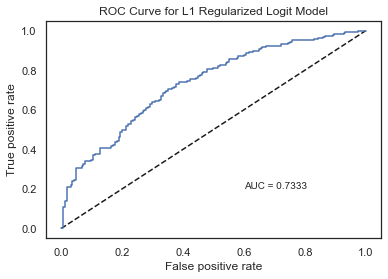

In [165]:
pipeline.set_params(logit_model_l1__C=best_C)
pipeline.fit(X_train,y_train)
y_prob_logit_lasso = pipeline.predict_proba(X_train_val)
fpr_logit_lasso, tpr_logit_lasso, _ = roc_curve(y_train_val, y_prob_logit_lasso[:, 1])
best_auc_logit_lasso = roc_auc_score(y_train_val, y_prob_logit_lasso[:,1])
plot_roc(fpr_logit_lasso, tpr_logit_lasso, 'ROC Curve for L1 Regularized Logit Model', 'AUC = %2.4f' % best_auc_logit_lasso)

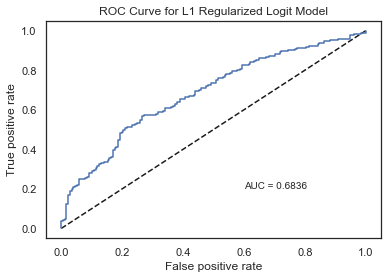

In [166]:
 #Test final model 
pipeline.set_params(logit_model_l1__C=best_C)
pipeline.fit(X_train,y_train)
y_prob_logit_lasso = pipeline.predict_proba(X_test)
fpr_logit_lasso, tpr_logit_lasso, _ = roc_curve(y_test, y_prob_logit_lasso[:, 1])
best_auc_logit_lasso = roc_auc_score(y_test, y_prob_logit_lasso[:, 1])
plot_roc(fpr_logit_lasso, tpr_logit_lasso, 'ROC Curve for L1 Regularized Logit Model', 'AUC = %2.4f' % best_auc_logit_lasso)

## C.2: with ridge regularization

In [167]:
estimators2 = []
estimators2.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators2.append(('ridge', Ridge()))  # tell it to use a logit model
pipeline2 = Pipeline(estimators2) 
#pipeline2.set_params(logit_model_l2__penalty='l2') 

In [169]:
# Tune C  
results2 = []
for c in np.logspace(-4, 5, 10):
    pipeline2.set_params(ridge__alpha=c) 
    pipeline2.fit(X_train_train,y_train_train)
    y_train_pred2 = pipeline2.predict(X_train_val)       # use validation set during hyper-parameter tuning
    auc_lml2 = roc_auc_score(y_train_val, y_train_pred2)   
    results2.append( (auc_lml2, c)  )
ridge = pipeline2.named_steps['ridge']      # capture model so we can use it later

In [170]:
# View results 
print('C'.center(12), '   ', 'AUC'.center(8), '\n', '=' * 25)
for (auc, c) in results2:
    print('{0:.4f}'.format(c).rjust(12), '   ',  '{0:.4f}'.format(auc).center(8))

     C             AUC    
      0.0001      0.6993 
      0.0010      0.6994 
      0.0100      0.6994 
      0.1000      0.6994 
      1.0000      0.6995 
     10.0000      0.6980 
    100.0000      0.6972 
   1000.0000      0.6971 
  10000.0000      0.6733 
 100000.0000      0.6576 


In [171]:
best_c=0.100

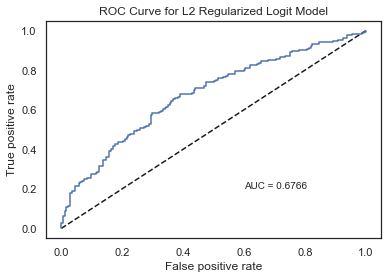

In [172]:
 #Test final model 
pipeline2.set_params(ridge__alpha=best_c)
pipeline2.fit(X_train,y_train)
y_prob_logit_ridge = pipeline2.predict(X_test)
fpr_logit_ridge, tpr_logit_ridge, _ = roc_curve(y_test, y_prob_logit_ridge)
best_auc_logit_ridge = roc_auc_score(y_test, y_prob_logit_ridge)
plot_roc(fpr_logit_ridge, tpr_logit_ridge, 'ROC Curve for L2 Regularized Logit Model', 'AUC = %2.4f' % best_auc_logit_ridge)

### Comparison of logistic models

In [173]:
logit_model_comp = Pipeline([('s', StandardScaler()), ('m', LogisticRegression(penalty='l2', C = 1e10))]).fit(X_train_train, y_train_train).named_steps['m']
print('REGULARIZATION'.center(20), 'NONE'.center(10), 'L1'.center(10))
print('=' * 50)
features = list(set(list(processed_data.columns)) - set(['raisingPrice','rf','closeDay1','offerPrice']))
for (varname, lm_coef, lml1_coef) in zip(features, logit_model_comp.coef_[0], logit_model_l1.coef_[0]):
    lm_coeff  = "{0:.4f}".format(lm_coef).rjust(10)
    lml1_coef = "{0:.4f}".format(lml1_coef).rjust(10) if lml1_coef > 0.0001 else ""
    
    print(str(varname).center(20), lm_coeff, lml1_coef)

   REGULARIZATION       NONE        L1    
industryFF12_Healthcare, Medical Equipment, and Drugs     0.5147     0.4750
         vc              0.0568     0.0503
 nasdaq2weeksBefore      0.0258 
         pe             -0.0369 
industryFF12_Finance    -0.0631 
 investmentReceived      0.0995     0.1009
industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment    -0.3889 
     netIncome          -0.6805 
      ipoSize           -0.1431 
    industryFF48         0.1250 
   totalProceeds        -0.0517 
   priorFinancing       -0.2242 
   commonEquity2         0.0327     0.0310
      leverage          -0.2320 
industryFF12_Oil, Gas, and Coal Extraction and Products     0.0783 
        roa              0.4350     0.3150
industryFF12_Telephone and Television Transmission    -0.0199 
     bookValue           0.2795     0.2299
    totalAssets          0.1973     0.2430
      blueSky           -0.2122 
        egc              0.3640     0.1219
    nExecutives         -0

### Comments

The AUC is correct

## D. KNN

In this section, we build the pipeline to classify positive and negative cases in the given data set

In [174]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [442]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', KNeighborsClassifier(n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__n_neighbors' : range(1, 101, 5),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
knn_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============... Training the KNN model...===============
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.1s



Best parameter (CV score =0.644):
{'model__n_neighbors': 51}

===============Training results with cross validation...===============



[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.7s finished


,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
10,0.644,0.009,1,0.691,0.009
13,0.644,0.014,2,0.687,0.007
12,0.644,0.013,3,0.688,0.005
8,0.642,0.006,4,0.693,0.007
18,0.642,0.013,5,0.676,0.005
15,0.642,0.014,6,0.682,0.004
11,0.641,0.012,7,0.690,0.007
9,0.641,0.005,8,0.691,0.008
16,0.641,0.016,9,0.680,0.004
17,0.641,0.016,10,0.678,0.004


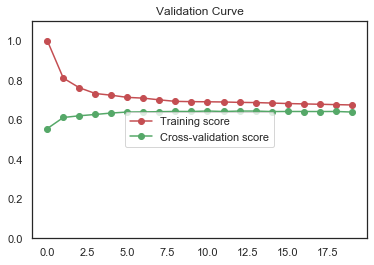

In [176]:
knn_model_final = custom_train_test_function(knn_model, X_train, y_train, name="KNN model", proba=True, plot_train_score=True)


## E. Decision trees

In [177]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [443]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', DecisionTreeClassifier(random_state=SEED)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__max_depth' : range(1, 30, 2),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
decision_trees_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============... Training the Decision tree model...===============
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.645):
{'model__max_depth': 3}

===============Training results with cross validation...===============



[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
1,0.645,0.007,1,0.703,0.005
2,0.639,0.018,2,0.786,0.005
3,0.626,0.035,3,0.865,0.010
0,0.594,0.010,4,0.594,0.005
4,0.578,0.046,5,0.936,0.013
10,0.566,0.008,6,1.000,0.000
11,0.566,0.008,6,1.000,0.000
12,0.566,0.008,6,1.000,0.000
13,0.566,0.008,6,1.000,0.000
14,0.566,0.008,6,1.000,0.000


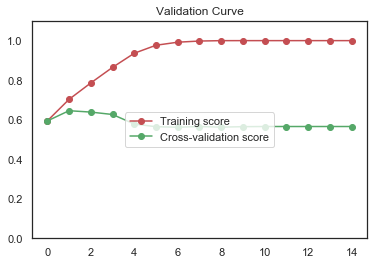

In [179]:
decision_trees_model_final = custom_train_test_function(decision_trees_model, X_train, y_train, name="Decision tree model", proba=True, plot_train_score=True)


In [180]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [181]:
# Build pipeline
estimators = []
estimators.append(('DTC_model', DecisionTreeClassifier()))
pipeline = Pipeline(estimators) 


### Validation and hyper parameter tuning

In [182]:
# Tune D   
results = []
for D in range(1,32):
    pipeline.set_params(DTC_model__max_depth=D) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_dtc = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append((auc_dtc, D))

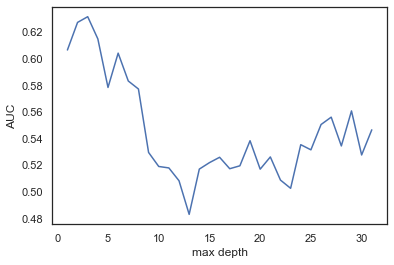

In [183]:
# View results 
df = pd.DataFrame(results)
plt.figure(1)
plt.plot(df[1],df[0])
plt.xlabel('max depth')
plt.ylabel('AUC')
plt.show()

In [184]:
# Select best D
r = np.array(results)
best_D = r[np.argmax(r[:,0]),1]
print ('"best_D" = ', best_D)

"best_D" =  3.0


### Test the model

In [185]:
# Test model
y_test_pred_DT = pipeline.predict_proba(X_test) 
dtc = DecisionTreeClassifier().fit(X_train,y_train)
y_train_predDT = dtc.predict_proba(X_test)
auc_DT = roc_auc_score(y_test, y_train_predDT[:,1])
auc_DT

0.5332254310031279

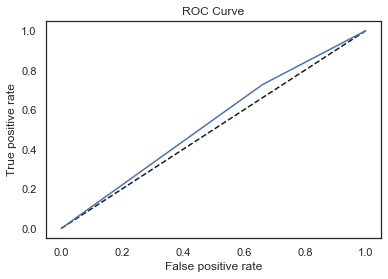

0.5332254310031279


In [186]:
# Plot the ROC
fpr, tpr , _ = roc_curve(y_test, y_train_predDT[:,1])
auc = roc_auc_score(y_test, y_train_predDT[:,1])
plot_roc(fpr, tpr)
print(auc)



## F. Random forests

In [187]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [444]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', RandomForestClassifier(n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__n_estimators' : range(100, 251, 10),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
random_forests_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============... Training the Random forests model...===============
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   31.0s finished



Best parameter (CV score =0.687):
{'model__n_estimators': 191}

===============Training results with cross validation...===============



,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
19,0.687,0.007,1,1.0,9.065e-17
21,0.687,0.010,2,1.0,6.410e-17
14,0.685,0.005,3,1.0,0.000e+00
11,0.685,0.010,4,1.0,6.410e-17
18,0.685,0.005,5,1.0,0.000e+00
16,0.684,0.007,6,1.0,6.410e-17
15,0.684,0.019,7,1.0,0.000e+00
24,0.684,0.007,8,1.0,6.410e-17
23,0.684,0.007,9,1.0,6.410e-17
17,0.684,0.010,10,1.0,0.000e+00


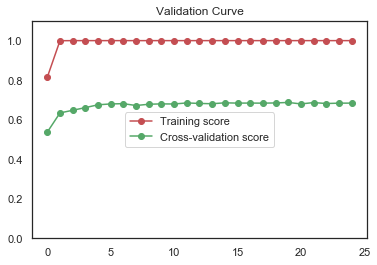

In [189]:
random_forests_model_final = custom_train_test_function(random_forests_model, X_train, y_train, name="Random forests model", proba=True, plot_train_score=True)

  Feature        Importance
 offerPrice       0.0400 
  leverage        0.0383 
    roa           0.0380 
reputationAvg      0.0372 
commonEquity2      0.0368 
sharesOfferedPerc      0.0351 
    rf_3          0.0341 
totalAssets       0.0328 
    rf_0          0.0327 
commonEquity1      0.0324 
    rf_1          0.0322 
 bookValue        0.0316 
    rf_2          0.0313 
reputationSum      0.0306 
 netIncome        0.0305 
totalProceeds      0.0305 
amountOnProspectus      0.0290 
totalRevenue      0.0287 
    age           0.0279 
sp2weeksBefore      0.0278 
nasdaq2weeksBefore      0.0277 
dj2weeksBefore      0.0272 
managementFee      0.0227 
  ipoSize         0.0219 
nUnderwriters      0.0206 
reputationLeadAvg      0.0200 
  patRatio        0.0198 
priorFinancing      0.0197 
investmentReceived      0.0196 
    nVCs          0.0176 
    year          0.0174 
nExecutives       0.0169 
  blueSky         0.0152 
reputationLeadMax      0.0137 
  nPatents        0.0100 
  highTech      

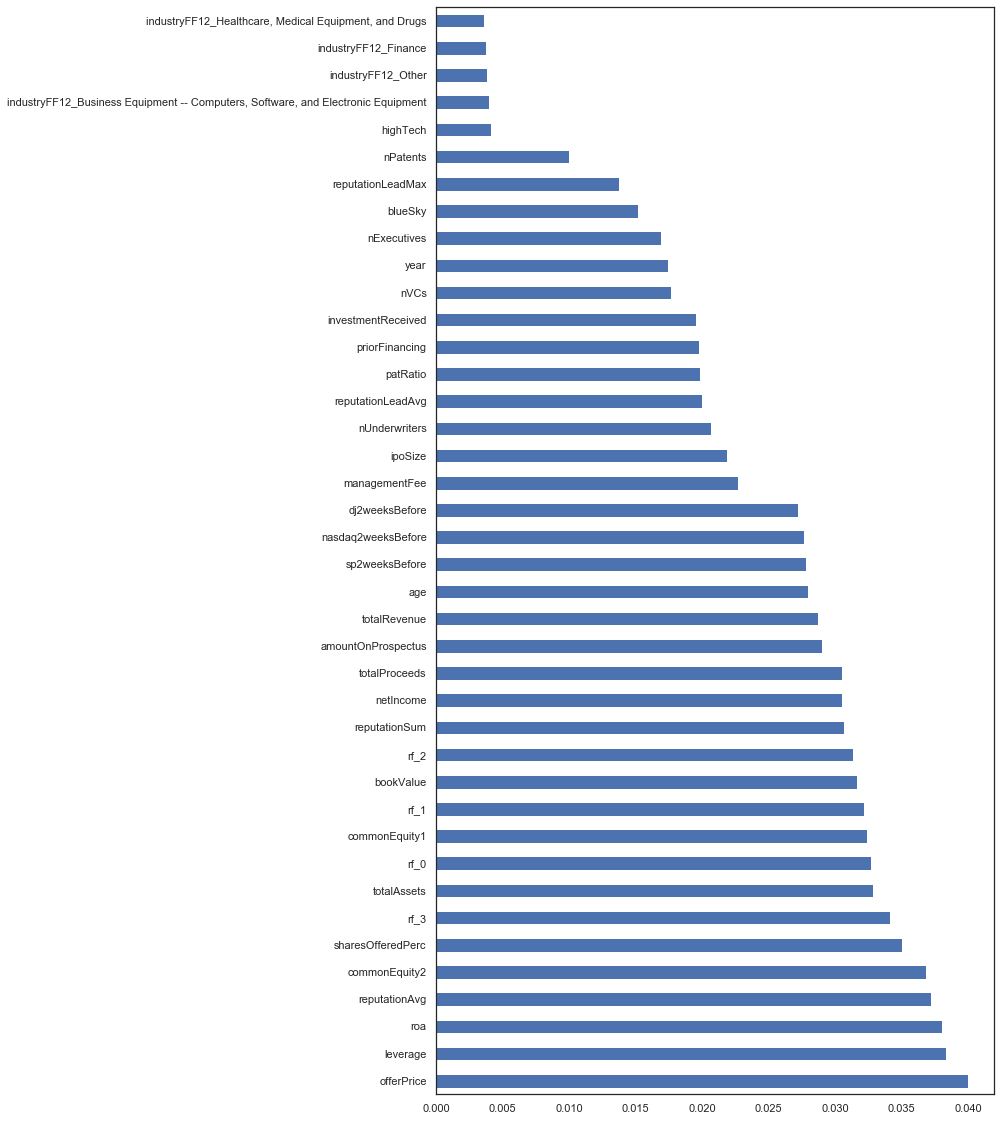

In [190]:
# Print feature importance
columns = X.columns
feat_importances = pd.Series(random_forests_model_final.best_estimator_.named_steps['model'].feature_importances_, index=columns)
plt.figure(figsize=(10,20))
feat_importances.nlargest(40).plot(kind='barh')

print_feature_importance(random_forests_model_final.best_estimator_.named_steps['model'], feature_names= columns)

**Comments**: we can see that the most important features in this model are the offer price, the leverage, the roa and the reputation average. It seems not to be so surprising as these are pretty basic finance information that gives an idea of the profitability of a company.

In [191]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
#X = data.loc[:, features]

In [192]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [193]:
# Build pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('rfc_model', RandomForestClassifier()))
pipeline = Pipeline(estimators) 

### Validation and hyper parameter tuning

In [194]:
# Tune N   
results = []
for N in range(1,250,10):
    pipeline.set_params(rfc_model__n_estimators=N) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_rfc = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append((auc_rfc, N))

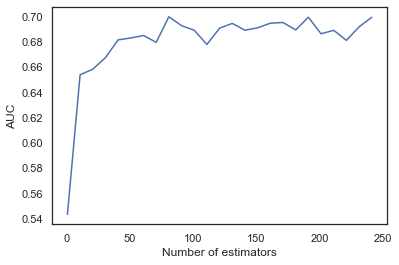

In [195]:
# View results 
df = pd.DataFrame(results)
plt.figure(1)
plt.plot(df[1],df[0])
plt.xlabel('Number of estimators')
plt.ylabel('AUC')
plt.show()

In [196]:
# Select best N
r = np.array(results)
best_N = r[np.argmax(r[:,0]),1]
print ('"best_N" = ', best_N)

"best_N" =  81.0


### Test the model

In [197]:
# Test final model
pipeline.set_params(rfc_model__n_estimators=int(best_N))
RFM = pipeline.fit(X_train,y_train)
y_test_pred_RF = pipeline.predict_proba(X_test) 

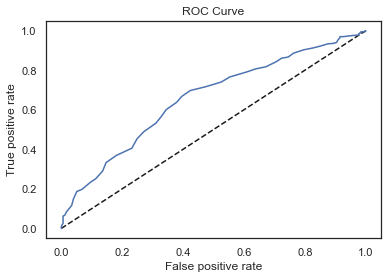

0.6568887757328872


In [198]:
# Plot the ROC

fpr, tpr , _ = roc_curve(y_test, y_test_pred_RF[:,1])
auc = roc_auc_score(y_test, y_test_pred_RF[:,1])
plot_roc(fpr, tpr)
print(auc)


## G. Support Vector Machines Classifier : SVC

Using numeric data and SVC classifier for predicting positive and negatve cases

In [199]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [445]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', SVC(probability=True, random_state=SEED, max_iter=1000)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__C' : np.logspace(-2, 3, 5),
    'model__kernel' : ('linear', 'rbf')
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
svc_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============... Training the SVC model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.0s finished



Best parameter (CV score =0.651):
{'model__C': 0.1778279410038923, 'model__kernel': 'rbf'}

===============Training results with cross validation...===============



,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
3,0.651,0.014,1,0.871,0.008
5,0.649,0.012,2,0.896,0.011
1,0.648,0.014,3,0.870,0.006
0,0.603,0.013,4,0.629,0.020
7,0.602,0.019,5,0.887,0.022
2,0.593,0.035,6,0.616,0.022
9,0.561,0.035,7,0.823,0.027
4,0.531,0.033,8,0.539,0.025
6,0.515,0.024,9,0.519,0.019
8,0.515,0.024,9,0.519,0.019


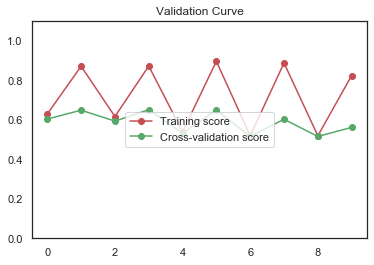

In [201]:
svc_model_final = custom_train_test_function(svc_model, X_P1, y_P1, name="SVC model", proba=True, plot_train_score=True)


In [202]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [203]:
# Build pipeline for features except 'rf'
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('svc', SVC(C=1, probability=True, random_state=SEED, max_iter=500)))
pipeline = Pipeline(estimators) 

### Train the model

In [204]:
# Tune K
results = []
for c in np.logspace(-4, 5, 10):
    pipeline.set_params(svc__C=c) 
    pipeline.fit(X_train_train,y_train_train)
    y_hat = pipeline.predict_proba(X_train_val)
    auc = roc_auc_score(y_train_val, y_hat[:,1])
    results.append( (auc, c) )
    

In [205]:
# View results 
print('C'.rjust(5), '   ', 'AUC'.center(8), '\n', '=' * 20)
for (auc, k) in results:
    print('{0}'.format(k).rjust(5), '   ',  '{0:.4f}'.format(auc).center(8))

    C       AUC    
0.0001      0.6097 
0.001      0.6082 
 0.01      0.6094 
  0.1      0.6216 
  1.0      0.6673 
 10.0      0.6118 
100.0      0.5824 
1000.0      0.5640 
10000.0      0.5640 
100000.0      0.5640 


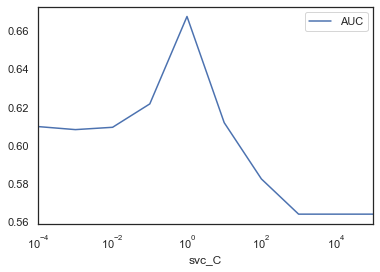

In [206]:
df_auc_svc = pd.DataFrame(results, columns=['AUC', 'svc_C'])

df_auc_svc.plot('svc_C', 'AUC', logx=True)
plt.savefig('svc_C_numeric.png')

### Validation and hyper parameter tuning

In [207]:
param_grid = {
    'svc__C': np.logspace(-2, 3, 5),
}
cv = ShuffleSplit(n_splits=2, test_size=0.25, random_state=SEED)
search = GridSearchCV(pipeline, param_grid, iid=False, cv=cv)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.753):
{'svc__C': 0.1778279410038923}


## H. Support Vector Regression

In [446]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', SVR(kernel='linear', max_iter=500)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__C' : np.logspace(-2, 3, 5),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
svr_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric_regression, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============... Training the SVR model...===============
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-0.242):
{'model__C': 0.01}

===============Training results with cross validation...===============



[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished


,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,-0.242,0.035,1,-0.231,0.041
1,-0.815,0.555,2,-0.870,0.493
2,-6.676,1.916,3,-6.660,2.231
3,-15.751,15.863,4,-15.308,15.344
4,-80.067,75.324,5,-79.483,75.250


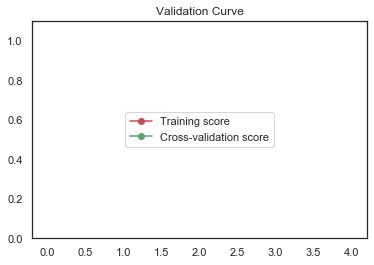

In [209]:
svr_model_final = custom_train_test_function(svr_model, X_P2, y_P2, name="SVR model", proba=True, plot_train_score=True, test_req=True, custom_test=True)

## I. Neural net classifier (NN)

In [210]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [447]:
# Pipeline
estimators = []
estimators.append(('standardize', scaling_metric))         # tell it to standardize features
estimators.append(('model', MLPClassifier(solver='lbfgs', random_state=SEED)))
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__alpha' : np.logspace(-4, 5, 10),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
cnn_model = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.0s finished



Best parameter (CV score =0.676):
{'model__alpha': 100.0}

===============Training results with cross validation...===============



,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
6,0.676,0.015,1,0.715,0.006
7,0.656,0.023,2,0.677,0.006
5,0.646,0.016,3,0.982,0.001
4,0.625,0.023,4,1.000,0.000
3,0.608,0.020,5,1.000,0.000
2,0.599,0.024,6,1.000,0.000
1,0.597,0.018,7,1.000,0.000
0,0.591,0.026,8,1.000,0.000
9,0.569,0.023,9,0.572,0.013
8,0.370,0.024,10,0.355,0.015


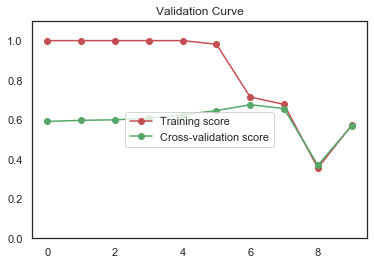

In [212]:
cnn_model_final = custom_train_test_function(cnn_model, X_train, y_train, name="CNN model", proba=True, plot_train_score=True, test_req=True)

# Part 5: Ensembles

Ensemble modeling is a process where multiple diverse base models are used to predict an outcome.  Even though the ensemble model has multiple base models within the model, it acts and performs as a single model. Most of the practical data science applications utilize ensemble modeling techniques.

In this section, we try ensembles on the above trained baseline estimators and compare the performance for P1

In [228]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [448]:
ensemble_random       = BaggingClassifier(random_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
ensemble_baseline     = BaggingClassifier(baseline_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
ensemble_logit        = BaggingClassifier(logit_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
ensemble_linear       = BaggingRegressor(linear_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
ensemble_knn          = BaggingClassifier(knn_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
ensemble_decision_tree= BaggingClassifier(decision_trees_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
ensemble_random_forest= BaggingClassifier(random_forests_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
ensemble_svc          = BaggingClassifier(svc_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
ensemble_svr          = BaggingRegressor(svr_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
ensemble_cnn          = BaggingClassifier(cnn_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)

### Ensembling tests


===============ROC curve on the Test data ...===============



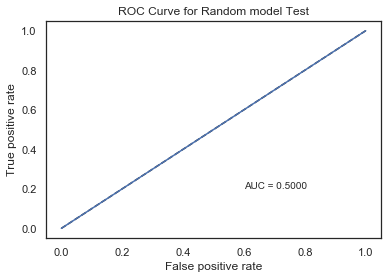


===============ROC curve on the Test data ...===============



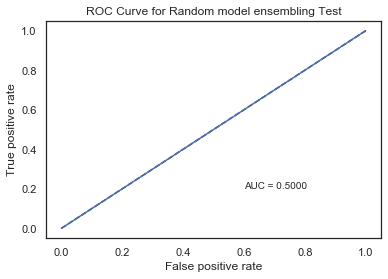

0.5

In [215]:
# Random model
custom_test_function(random_model_final, X_test, y_test, proba=True, name="Random model Test")
custom_test_function(ensemble_random.fit(X_train, y_train), X_test, y_test, proba=True, name="Random model ensembling Test")


===============ROC curve on the Test data ...===============



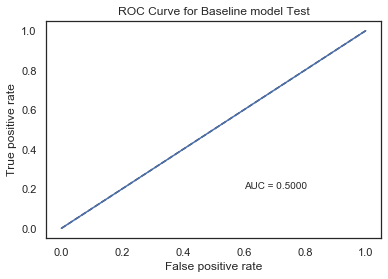


===============ROC curve on the Test data ...===============



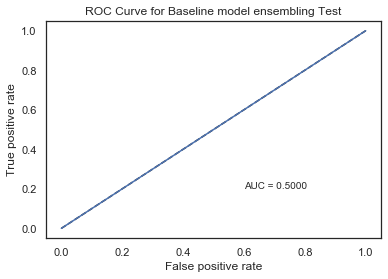

0.5

In [216]:
# Baseline
custom_test_function(baseline_model_final, X_test, y_test, proba=True, name="Baseline model Test")
custom_test_function(ensemble_baseline.fit(X_train, y_train), X_test, y_test, proba=True, name="Baseline model ensembling Test")


===============ROC curve on the Test data ...===============



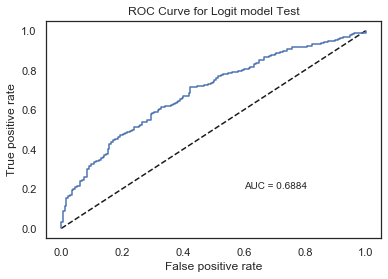


===============ROC curve on the Test data ...===============



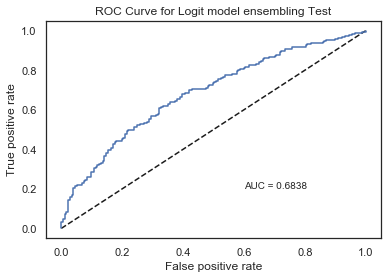

0.683821924783589

In [217]:
# Logit model
custom_test_function(logit_model_final, X_test, y_test, proba=True, name="Logit model Test")
custom_test_function(ensemble_logit.fit(X_train, y_train), X_test, y_test, proba=True, name="Logit model ensembling Test")


===============ROC curve on the Test data ...===============



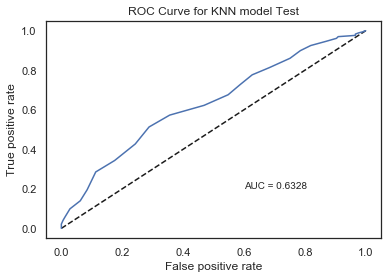


===============ROC curve on the Test data ...===============



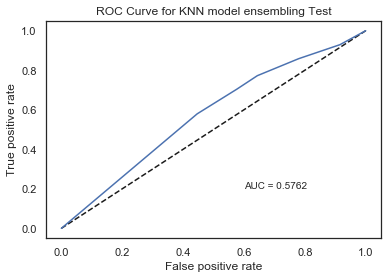

0.5762287529400354

In [223]:
# knn model
custom_test_function(knn_model_final, X_test, y_test, proba=True, name="KNN model Test")
custom_test_function(ensemble_knn.fit(X_train, y_train), X_test, y_test, proba=True, name="KNN model ensembling Test")


===============ROC curve on the Test data ...===============



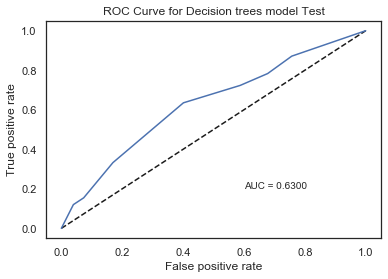


===============ROC curve on the Test data ...===============



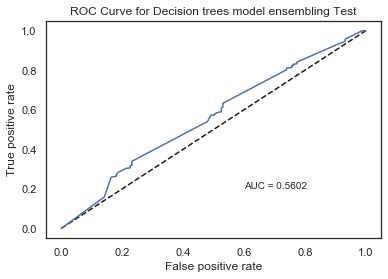

0.560213137411799

In [224]:
# Decision trees model
custom_test_function(decision_trees_model_final, X_test, y_test, proba=True, name="Decision trees model Test")
custom_test_function(ensemble_decision_tree.fit(X_train, y_train), X_test, y_test, proba=True, name="Decision trees model ensembling Test")


===============ROC curve on the Test data ...===============



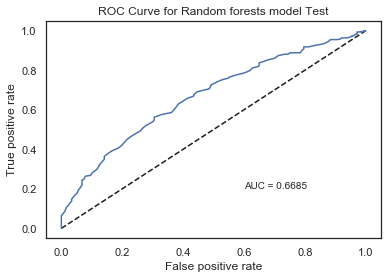


===============ROC curve on the Test data ...===============



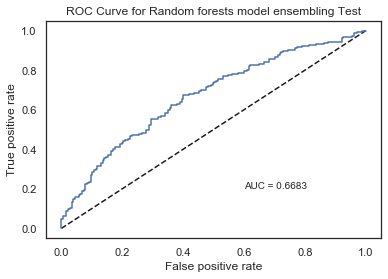

0.6683033874057369

In [225]:
# Random forests model
custom_test_function(random_forests_model_final, X_test, y_test, proba=True, name="Random forests model Test")
custom_test_function(ensemble_random_forest.fit(X_train, y_train), X_test, y_test, proba=True, name="Random forests model ensembling Test")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.9s finished



===============ROC curve on the Test data ...===============



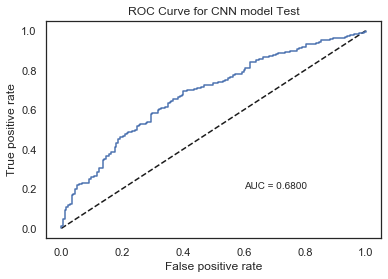


===============ROC curve on the Test data ...===============



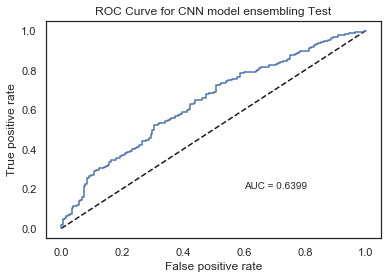

0.6398729419752189

In [230]:
# CNN model
custom_test_function(cnn_model_final, X_test, y_test, proba=True, name="CNN model Test")
custom_test_function(ensemble_cnn.fit(X_train, y_train), X_test, y_test, proba=True, name="CNN model ensembling Test")

**Comments**: according to the AUC, the best models are the logit one, the random forests one and the neural network. Moreover, it seems that ensembling allows to increase the AUC in most cases, so we will use it in the following.

# Part 6: Prediction

Prediction based on the predict xls features for each of P1 to P9

## Pre-processing of the dataset used for the predictions

In [231]:
df_predict=pd.read_excel("IPO_data_to_predict.xlsx", index_col=0)

In [232]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 2750 to 1370
Data columns (total 54 columns):
offerPrice            370 non-null float64
rf                    338 non-null object
egc                   370 non-null bool
html                  370 non-null bool
patRatio              234 non-null float64
city                  369 non-null object
issuer                370 non-null object
highTech              370 non-null bool
age                   343 non-null float64
exchange              370 non-null object
year                  370 non-null int64
industryFF5           370 non-null object
industryFF12          370 non-null object
industryFF48          370 non-null object
nUnderwriters         370 non-null int64
sharesOfferedPerc     329 non-null float64
totalProceeds         370 non-null int64
manager               370 non-null object
investmentReceived    196 non-null float64
amountOnProspectus    370 non-null float64
commonEquity          297 non-null float64
sp2weeksBef

### Process the Prediction data features

Changing the name of the collumn 

In [233]:
df_predict = df_predict.rename(columns={"commonEquity":"commonEquity1","commonEquity.1":"commonEquity2" })

### Replacing the null fields

We decide to fill the empty data using the mean or the median according to the way whe chose in the pre-processing of the training dataset. It would have been better to use the mean and median from the training dataset and not from theone we need to predict. 

In [234]:
processed_data_predict = copy.deepcopy(df_predict)

In [235]:
processed_data_predict.replace([np.inf, -np.inf], np.nan, inplace=True)

In [236]:
processed_data_predict['age'].fillna(processed_data_predict['age'].median(), inplace=True)

In [237]:
processed_data_predict['blueSky'].fillna(processed_data_predict['blueSky'].median(), inplace=True)

We fill the null "Risk factor" field with ""

In [238]:
processed_data_predict.rf.fillna(" ", inplace=True)

Also, one city is missing, we will replace it with a blank 

In [239]:
processed_data_predict.city.fillna(" ", inplace=True)

In [240]:
processed_data_predict['patRatio'].fillna(processed_data_predict['patRatio'].median(), inplace=True)

In [241]:
replace_mean = ["sharesOfferedPerc", "investmentReceived", "commonEquity1", "managementFee", "commonEquity2", "bookValue", "totalAssets", "totalRevenue", "netIncome", "roa", "leverage", "priorFinancing", "ipoSize"]

In [242]:
processed_data[replace_mean].head(2)

,sharesOfferedPerc,investmentReceived,commonEquity1,managementFee,commonEquity2,bookValue,totalAssets,totalRevenue,netIncome,roa,leverage,priorFinancing,ipoSize
issuer,,,,,,,,,,,,,
Numerical Technologies Inc,30.50,64190.000,-0.880,9.244e+05,100.00,219.134,240.974,23.34,-48.811,-0.203,0.000,64190.000,6.811e+07
"Home BancShares Inc,Conway,AR",17.09,172172.815,0.063,2.070e+06,40.99,231.419,2190.648,142.89,15.918,0.007,0.155,130854.105,1.454e+08


In [243]:
processed_data_predict[replace_mean] = processed_data_predict[replace_mean].apply(lambda x: x.fillna(x.mean()),axis=0)

In [244]:
replace_median = ["nExecutives", "nVCs"]

In [245]:
processed_data_predict[replace_median] = processed_data_predict[replace_median].apply(lambda x: x.fillna(x.median()),axis=0)

In [246]:
processed_data_predict.shape

(370, 54)

In [247]:
processed_data_predict.head(2)

,offerPrice,rf,egc,html,patRatio,city,issuer,highTech,age,exchange,...,nPatents,P1,P2,P3,P4,P5,P6,P7,P8,P9
2750,17.0,RISK FACTORS Before you invest in our common s...,False,False,0.132,SAN JOSE,PCTEL Inc,True,5.0,NASDQ,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2551,14.0,,False,True,0.449,MC,Gaslog Ltd,False,9.0,NYSE,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


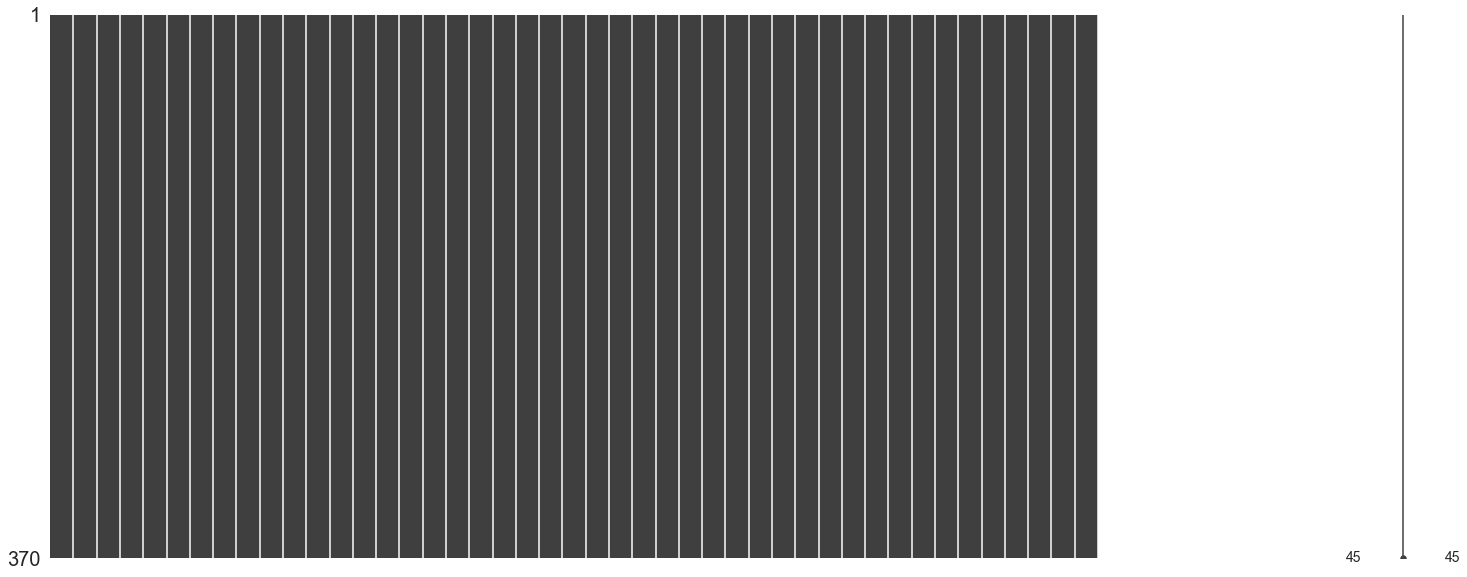

In [248]:
msno.matrix(processed_data_predict)

**Comments**: we can see that there is no missing data anymore.

### Processing the fields (Addition, deletion)

'issuer' is unique, hence will not be a useful feature for prediction. We drop it from the list of useful features and set it as index.

We create dummies for 'Exchange' and for 'industryFF12' and we drop ['manager', 'city'] as we dropped them in the training process.

Update True/False fields to 1/0

In [249]:
# Unique field 'issuer' is made index of the cell
processed_data_predict.set_index('issuer', drop=True, inplace=True)
processed_data_predict = pd.get_dummies(data=processed_data_predict, columns= ['exchange', 'industryFF12'])
processed_data_predict.drop(['manager', 'city'], axis=1, inplace=True)

In [250]:
processed_data_predict[processed_data_predict.select_dtypes([np.bool]).columns] = processed_data_predict.select_dtypes([np.bool]).astype(int)

We also drop every column P* as they won't be used to predict anything.

In [251]:
processed_data_predict.drop(['P1', 'P2','P3', 'P4','P5', 'P6','P7', 'P8','P9'], axis=1, inplace=True)

In [252]:
processed_data_predict.columns

Index(['offerPrice', 'rf', 'egc', 'html', 'patRatio', 'highTech', 'age',
       'year', 'industryFF5', 'industryFF48', 'nUnderwriters',
       'sharesOfferedPerc', 'totalProceeds', 'investmentReceived',
       'amountOnProspectus', 'commonEquity1', 'sp2weeksBefore',
       'nasdaq2weeksBefore', 'dj2weeksBefore', 'blueSky', 'managementFee',
       'commonEquity2', 'bookValue', 'totalAssets', 'totalRevenue',
       'netIncome', 'roa', 'leverage', 'vc', 'pe', 'prominence', 'nVCs',
       'nExecutives', 'priorFinancing', 'ipoSize', 'reputationLeadMax',
       'reputationLeadAvg', 'reputationSum', 'reputationAvg', 'nPatents',
       'exchange_AMEX', 'exchange_NASDQ', 'exchange_NYSE',
       'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
       'industryFF12_Chemicals and Allied Products',
       'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
       'industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, L

### Text pre-process on Risk Factor

We apply exactly the same text-processing to the predicting set than to the training one.

In [253]:
# Apply clean_re() to all features
processed_data_predict['rf'] = processed_data_predict['rf'].apply(clean_re)    
processed_data_predict['rf'].head(2)

issuer
PCTEL Inc     RISK FACTORS Before you invest in our common s...
Gaslog Ltd                                                     
Name: rf, dtype: object

In [254]:
# Apply lemmatize_text() to all features  
processed_data_predict['rf'] = processed_data_predict['rf'].apply(lemmatize_text)    
processed_data_predict['rf'].head(2)

issuer
PCTEL Inc     risk factor before you invest in our common st...
Gaslog Ltd                                                     
Name: rf, dtype: object

In [255]:
# Apply function to remove stopwords
processed_data_predict['rf'] = processed_data_predict['rf'].apply(clean_stopwords)    
processed_data_predict['rf'].head(2)

issuer
PCTEL Inc     invest various including described together in...
Gaslog Ltd                                                     
Name: rf, dtype: object

In [256]:
# Apply simple_preprocess() to all features
processed_data_predict['rf'] = processed_data_predict['rf'].apply(wrap_simple_preprocess)    
processed_data_predict['rf'].head(2)

issuer
PCTEL Inc     [invest, various, including, described, togeth...
Gaslog Ltd                                                   []
Name: rf, dtype: object

### Extracting features from 'rf'

In [257]:
id2word_predict = corpora.Dictionary(processed_data_predict['rf'])
corpus_predict = [id2word.doc2bow(doc) for doc in processed_data_predict['rf']]

### Extracting feature vector for each observation

In [258]:
rows_predict = processed_data_predict.rf.shape[0]
rows_predict

370

In [259]:
features_rf = []
for i in range(rows_predict):
    top_topics = selected_topic_model.get_document_topics(corpus_predict[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(int(no_topics_selected))]
    features_rf.append(topic_vec)

In [260]:
df_rf_features_pred = pd.DataFrame(features_rf, columns=range(int(no_topics_selected)), index=processed_data_predict.rf.index).add_prefix('rf_')
pd.concat([df_rf_features_pred, df_rf_features_pred.sum(axis=1)], axis=1).head(3)

,rf_0,rf_1,rf_2,rf_3,0
issuer,,,,,
PCTEL Inc,0.830,6.161e-04,0.101,0.068,1.0
Gaslog Ltd,0.265,2.423e-01,0.254,0.239,1.0
VIA NET.WORKS Inc,0.403,2.830e-03,0.327,0.267,1.0


### Feature extraction

In [261]:
X_data_predict = processed_data_predict

In [262]:
#We drop the text fields 'rf', 'industryFF12', 'industryFF48' and add the extracted features using text analysis
X_data_predict.drop(['rf', 'industryFF5', 'industryFF48'], axis=1, inplace=True)
X_predict = pd.concat([X_data_predict, df_rf_features_pred], axis=1, sort=False)

In [263]:
X_predict.head(2)


,offerPrice,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,...,"industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,industryFF12_Telephone and Television Transmission,industryFF12_Utilities,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3
issuer,,,,,,,,,,,,,,,,,,,,,
PCTEL Inc,17.0,0,0,0.132,1,5.0,1999,13,29.48,78200000,...,0,0,0,0,0,0,0.830,6.161e-04,0.101,0.068
Gaslog Ltd,14.0,0,1,0.449,0,9.0,2012,9,37.38,329000000,...,0,0,1,0,0,0,0.265,2.423e-01,0.254,0.239


In [264]:
incomplete = X_predict.columns[X_predict.isnull().any()].tolist()
incomplete

[]

In [265]:
Xp_P1 = X_data_predict
Xp_P2 = X_predict.filter(regex=("(rf_*)|(FF12_*)|(year)"))
# For all other predictors we use X_predict as the feature

In [266]:
assert(Xp_P1.shape[1] == X_P1.shape[1])

In [267]:
assert(Xp_P2.shape[1] == X_P2.shape[1])

In [268]:
assert(X_predict.shape[1] == X.shape[1])

### Custom function for traing all models for a given training data

In [449]:
def get_best_classifiers(X, y, plot_req=False, test_req=False, scoring='roc_auc', proba=False, pca_req=True, n_components = None):

    if pca_req:
        steps = len(random_model.estimator.steps)
        if n_components == None:
            n_components=X.shape[1]
        pca_final = PCA(n_components=n_components)

        if steps ==2 :
            random_model.estimator.steps.insert(1, ('pca', pca_final))
            linear_model.estimator.steps.insert(1, ('pca', pca_final))
            baseline_model.estimator.steps.insert(1, ('pca', pca_final))
            logit_model.estimator.steps.insert(1, ('pca', pca_final))
            knn_model.estimator.steps.insert(1, ('pca', pca_final))
            decision_trees_model.estimator.steps.insert(1, ('pca', pca_final))
            random_forests_model.estimator.steps.insert(1, ('pca', pca_final))
            svc_model.estimator.steps.insert(1, ('pca', pca_final))
            cnn_model.estimator.steps.insert(1, ('pca', pca_final))
    
    n_components = min(X.shape[1], n_components)
    random_model.estimator.set_params(pca__n_components=n_components)
    baseline_model.estimator.set_params(pca__n_components=n_components)
    linear_model.estimator.set_params(pca__n_components=n_components)
    logit_model.estimator.set_params(pca__n_components=n_components)
    knn_model.estimator.set_params(pca__n_components=n_components)
    decision_trees_model.estimator.set_params(pca__n_components=n_components)
    random_forests_model.estimator.set_params(pca__n_components=n_components)
    svc_model.estimator.set_params(pca__n_components=n_components)
    cnn_model.estimator.set_params(pca__n_components=n_components)
    
    # Update scoring metric for each of the pipelines
    random_model.scoring = scoring
    linear_model.scoring = scoring
    baseline_model.scoring = scoring
    logit_model.scoring = scoring
    knn_model.scoring = scoring
    decision_trees_model.scoring = scoring
    random_forests_model.scoring = scoring
    svc_model.scoring = scoring
    #svr_model.scoring = scoring
    cnn_model.scoring = scoring
    
    # Train each of the models
    if not proba :
        random_model_final = custom_train_test_function(random_model, X, y, name="Random model", proba=False, custom_test=False, test_req=test_req, plot_train_score=plot_req)
        #linear_model_final = custom_train_test_function(linear_model, X, y, name="Linear model", proba=False, custom_test=False, test_req=test_req, plot_train_score=plot_req)
        baseline_model_final = custom_train_test_function(baseline_model, X, y, name="Baseline model", proba=False, custom_test=False, test_req=test_req, plot_train_score=plot_req)

    logit_model_final = custom_train_test_function(logit_model, X, y, name="Logit model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    knn_model_final = custom_train_test_function(knn_model, X, y, name="KNN model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    decision_trees_model_final = custom_train_test_function(decision_trees_model, X, y, name="Decision trees model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    random_forests_model_final = custom_train_test_function(random_forests_model, X, y, name="Random forests model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    svc_model_final = custom_train_test_function(svc_model, X, y, name="SVC model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    cnn_model_final = custom_train_test_function(cnn_model, X, y, name="CNN model", proba=True, custom_test=False, test_req=test_req, plot_train_score=plot_req)
    
    if not proba:
        return [random_model_final, baseline_model_final, logit_model_final, knn_model_final, decision_trees_model_final, random_forests_model_final, svc_model_final, cnn_model_final]
    else :
        return [logit_model_final, knn_model_final, decision_trees_model_final, random_forests_model_final, svc_model_final, cnn_model_final]

In [450]:
def get_best_regressors(X, y):
    # Pipeline
    estimators = []
    estimators.append(('standardize', scaling_metric))         # tell it to standardize features
    estimators.append(('model', SVR(kernel='linear', max_iter=500)))  # tell it to use a logit model
    svr_model = Pipeline(estimators)
    
    estimators = []
    estimators.append(('standardize', scaling_metric))         # tell it to standardize features
    estimators.append(('model', LinearRegression()))  # tell it to use a logit model
    linear_model = Pipeline(estimators)
    
    svr_model_final = svr_model.fit(X, y)
    linear_model_final = linear_model.fit(X, y)
    return [linear_model_final, svr_model_final]


In [451]:
def test_final_models(models, X_test, y_test, greater_the_better=True):
    results = []
    index = []
    for model in models:
        score = model.score(X_test, y_test)
        name = f"{model.best_estimator_.named_steps['model'].__str__().split('(')[0]}"
        if name in index:
            name = name + '-1'
        index.append(name)
        #print(name, score)
        results.append((score, model))

    results = pd.DataFrame(results, index=index, columns=[scoring_metric, 'model'])#, index=range(len(P1_models)))
    results.sort_values(by=scoring_metric, ascending=(not greater_the_better), inplace=True)
    model_final = results.iloc[0]['model']
    results[[scoring_metric]]
    
    return model_final, results

In [452]:
custom_scorer_P7P8 = make_scorer(custom_scoring_metric_P7P8, greater_is_better=False, needs_proba=True)

In [453]:
custom_scorer_P9 = make_scorer(custom_scoring_metric_P9, greater_is_better=False, needs_proba=True)

## Prediction P1

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use all data from the dataset except for the rf variable (i.e., risk factors).


In [454]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P1, y_P1, test_size=0.2,  random_state=SEED)

In [455]:
# Pipeline
P1_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric, n_components=P1_n_components)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.500):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.671):
{'model__C': 1000.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.645):
{'model__n_neighbors': 86}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.589):
{'model__max_depth': 5}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   34.6s finished



Best parameter (CV score =0.657):
{'model__n_estimators': 230}
===============... Training the SVC model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.1s finished



Best parameter (CV score =0.640):
{'model__C': 0.1778279410038923, 'model__kernel': 'rbf'}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.8s finished



Best parameter (CV score =0.669):
{'model__alpha': 100.0}


### Test the trained models on test dataset

In [456]:
P1_model_final, P1_test_results = test_final_models(P1_models, X_test, y_test)
P1_test_results[[scoring_metric]]

,roc_auc
MLPClassifier,0.673
LogisticRegression,0.670
RandomForestClassifier,0.670
KNeighborsClassifier,0.641
SVC,0.640
DecisionTreeClassifier,0.591
DummyClassifier,0.500
DummyClassifier-1,0.500


In [457]:
P1_model_final = P1_model_final.fit(X_P1, y_P1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.1s finished


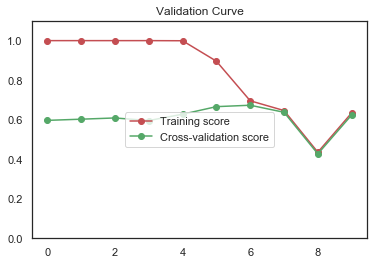

In [458]:
search_results = pd.DataFrame(P1_model_final.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))    
plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)


===============ROC curve on the Test data ...===============



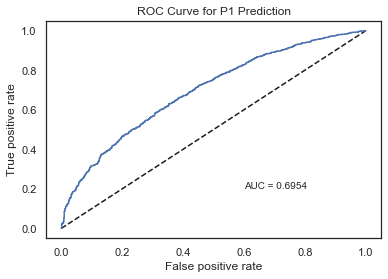

In [459]:
P1_auc = custom_test_function(P1_model_final, X_P1, y_P1, proba=True, name="P1 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



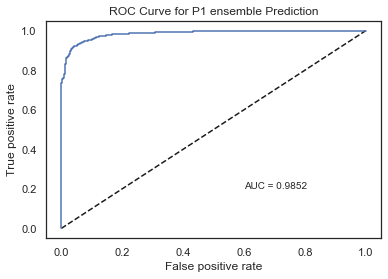

(0.6953724251351057, 0.985188176967127)

In [460]:
P1_ensemble_model = BaggingClassifier(P1_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P1_ensemble_model = P1_ensemble_model.fit(X_P1, y_P1)
P1_auc_en = custom_test_function(P1_ensemble_model, X_P1, y_P1, proba=True, name="P1 ensemble Prediction")
P1_auc, P1_auc_en

Using bagging classifier for P1 ... 


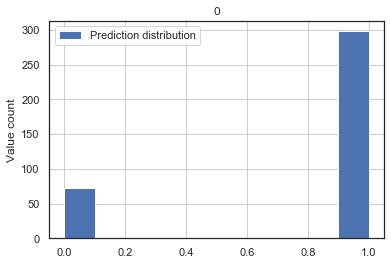

In [461]:
if P1_auc_en > P1_auc:
    print("Using bagging classifier for P1 ... ")
    P1_model_final = P1_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P1 = P1_model_final.predict(Xp_P1)
P1 = pd.DataFrame(yhat_P1, index=df_predict.index)
P1.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')

df_predict.P1 = P1

For P1 we can see that the best model is the MLP classifier, and also that all the models have a better AUC than the dummy classifiers. Finally, we constat that using the bagging classifier method allows to increase the AUC up to 0.98 which is pretty high.

## Prediction P2

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use only the rf (i.e., risk factors), year, and industryFF12 variables for this prediction task. You may, however, perform additional text analysis of the rf variable.


In [462]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P2, y_P2, test_size=0.2,  random_state=SEED)

In [463]:
# Pipeline
P2_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric, n_components=P2_n_components)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.592):
{'model__C': 0.01}
===============... Training the KNN model...===============
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.589):
{'model__n_neighbors': 21}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.564):
{'model__max_depth': 5}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   30.3s finished



Best parameter (CV score =0.583):
{'model__n_estimators': 240}
===============... Training the SVC model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.3s finished



Best parameter (CV score =0.562):
{'model__C': 56.23413251903491, 'model__kernel': 'linear'}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.5s finished



Best parameter (CV score =0.603):
{'model__alpha': 10.0}


### Test the trained models on test dataset

In [464]:
P2_model_final, P2_test_results = test_final_models(P2_models, X_test, y_test)
P2_test_results[[scoring_metric]]

,roc_auc
LogisticRegression,0.591
MLPClassifier,0.589
KNeighborsClassifier,0.584
DecisionTreeClassifier,0.572
RandomForestClassifier,0.562
DummyClassifier,0.500
DummyClassifier-1,0.500
SVC,0.467


### Retrain the final model on entire dataset and check the performance

In [465]:
P2_model_final = P2_model_final.fit(X_P2, y_P2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


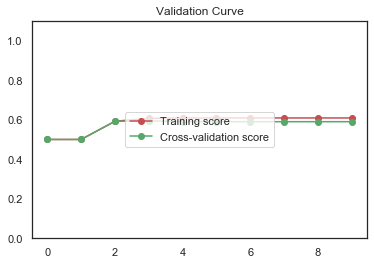

In [466]:
search_results = pd.DataFrame(P2_model_final.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))    
plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)


===============ROC curve on the Test data ...===============



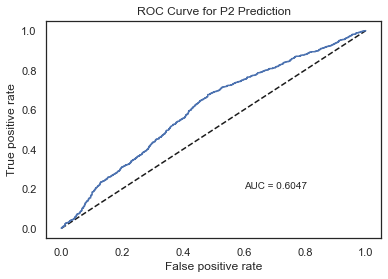

In [467]:
P2_auc = custom_test_function(P2_model_final, X_P2, y_P2, proba=True, name="P2 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



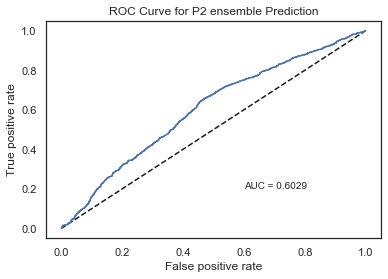

(0.6046604566615918, 0.6028752303477463)

In [468]:
P2_ensemble_model = BaggingClassifier(P2_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P2_ensemble_model = P2_ensemble_model.fit(X_P2, y_P2)
P2_auc_en = custom_test_function(P2_ensemble_model, X_P2, y_P2, proba=True, name="P2 ensemble Prediction")
P2_auc, P2_auc_en

Using the model without ensembling ...


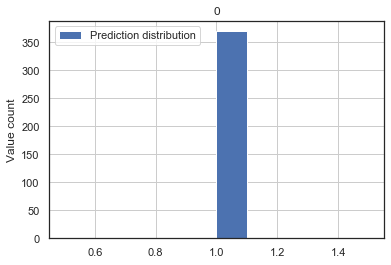

In [469]:
if P2_auc_en > P2_auc:
    print("Using bagging classifier for P2 ... ")
    P2_model_final = P2_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P2 = P2_model_final.predict(Xp_P2)
P2 = pd.DataFrame(yhat_P2, index=df_predict.index)
P2.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

df_predict.P2 = P2

For P2 the best model is a logistic regression but the AUC is very low so we can not be confident in our prediction. It probably means that the year, the risk factors and the type of industry are not enough to predict if the price will go up or down at the end of the first day, especially as the year is the main parameter for the random forest classifier.  

For all remaining problems, you may use any or all of the features.

## Prediction P3

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price.


In [470]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P3, test_size=0.2,  random_state=SEED)

In [471]:
# Pipeline
P3_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric, n_components=P3_n_components)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.682):
{'model__C': 100000.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.642):
{'model__n_neighbors': 91}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.592):
{'model__max_depth': 5}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   30.3s finished



Best parameter (CV score =0.662):
{'model__n_estimators': 120}
===============... Training the SVC model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s finished



Best parameter (CV score =0.644):
{'model__C': 0.1778279410038923, 'model__kernel': 'rbf'}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.2s finished



Best parameter (CV score =0.671):
{'model__alpha': 100.0}


### Test the trained models on test dataset

In [472]:
P3_model_final, P3_test_results = test_final_models(P3_models, X_test, y_test)
P3_test_results[[scoring_metric]]

,roc_auc
LogisticRegression,0.680
MLPClassifier,0.674
RandomForestClassifier,0.658
SVC,0.645
KNeighborsClassifier,0.641
DecisionTreeClassifier,0.637
DummyClassifier,0.500
DummyClassifier-1,0.500


### Retrain the final model on entire dataset and check the performance

In [473]:
P3_model_final = P3_model_final.fit(X, y_P3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


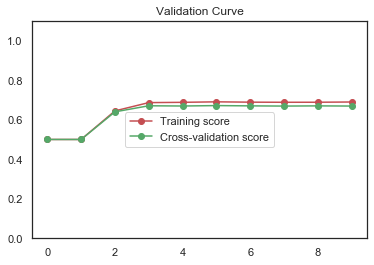

In [474]:
search_results = pd.DataFrame(P3_model_final.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))    
plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)


===============ROC curve on the Test data ...===============



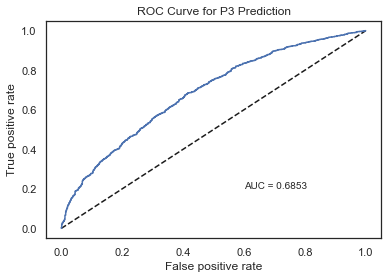

In [475]:
P3_auc = custom_test_function(P3_model_final, X, y_P3, proba=True, name="P3 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



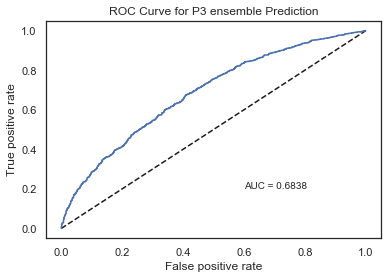

(0.6853277118974047, 0.6837887236958138)

In [476]:
P3_ensemble_model = BaggingClassifier(P3_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P3_ensemble_model = P3_ensemble_model.fit(X, y_P3)
P3_auc_en = custom_test_function(P3_ensemble_model, X, y_P3, proba=True, name="P3 ensemble Prediction")
P3_auc, P3_auc_en

Using the model without ensembling ...


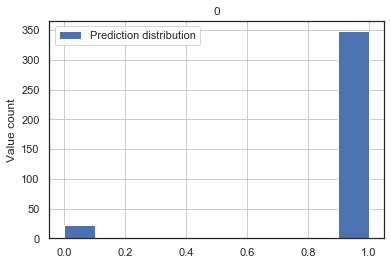

In [477]:
if P3_auc_en > P3_auc:
    print("Using bagging classifier for P3 ... ")
    P3_model_final = P3_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P3 = P3_model_final.predict(X_predict)
P3 = pd.DataFrame(yhat_P3, index=df_predict.index)
P3.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [478]:
df_predict.P3 = P3

As previously, the logistic model and the neural network are the best one, and the ensembling does not allow any improvement. As the AUC is lower than for P1 it seems that this model is perhaps overfitting: we may have chosen only the most important features. Except this, the AUC of the models are better than the one of the dummies so the models are correct.

## Prediction P4

    Predict whether the closing price at the end of the first day of trading will go up by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).

In [479]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P4, test_size=0.2,  random_state=SEED)

In [480]:
# Pipeline
P4_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric, n_components=P3_n_components)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.773):
{'model__C': 1000.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.767):
{'model__n_neighbors': 76}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.692):
{'model__max_depth': 3}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   29.3s finished



Best parameter (CV score =0.782):
{'model__n_estimators': 230}
===============... Training the SVC model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished



Best parameter (CV score =0.770):
{'model__C': 3.1622776601683795, 'model__kernel': 'rbf'}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.3s finished



Best parameter (CV score =0.783):
{'model__alpha': 10.0}


### Test the trained models on test dataset

In [481]:
P4_model_final, P4_test_results = test_final_models(P4_models, X_test, y_test)
P4_test_results[[scoring_metric]]

,roc_auc
RandomForestClassifier,0.801
LogisticRegression,0.796
KNeighborsClassifier,0.792
SVC,0.792
MLPClassifier,0.790
DecisionTreeClassifier,0.727
DummyClassifier,0.500
DummyClassifier-1,0.500


### Retrain the final model on entire dataset and check the performance

In [482]:
P4_model_final = P4_model_final.fit(X, y_P4)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   34.5s finished


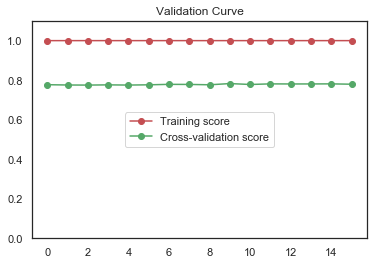

In [483]:
search_results = pd.DataFrame(P4_model_final.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))    
plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)


===============ROC curve on the Test data ...===============



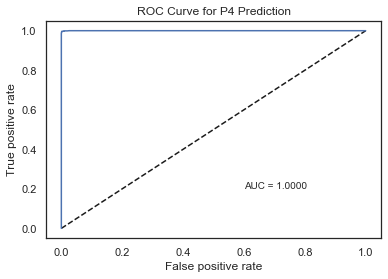

In [484]:
P4_auc = custom_test_function(P4_model_final, X, y_P4, proba=True, name="P4 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



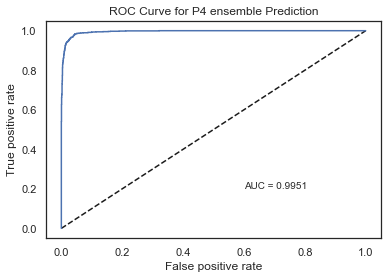

(0.9999541868807008, 0.9951107099236038)

In [485]:
P4_ensemble_model = BaggingClassifier(P4_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P4_ensemble_model = P4_ensemble_model.fit(X, y_P4)
P4_auc_en = custom_test_function(P4_ensemble_model, X, y_P4, proba=True, name="P4 ensemble Prediction")
P4_auc, P4_auc_en

Using the model without ensembling ...


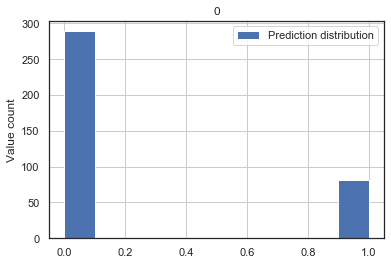

In [486]:
if P4_auc_en > P4_auc:
    print("Using bagging classifier for P4 ... ")
    P4_model_final = P4_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P4 = P4_model_final.predict(X_predict)
P4 = pd.DataFrame(yhat_P4, index=df_predict.index)
P4.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [487]:
df_predict.P4 = P4

Here we have used all the features available. The random forest classifier seems to be the best model, followed by the logistic regression. The ensembles don't improve the AUC so it is not used for the prediction, which makes sense as random forest already uses bagging. The histogram of the prediction is similar to the training one so we may be confident in our results.

## Prediction P5

    Predict whether the closing price at the end of the first day of trading will go down by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).


In [488]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P5, test_size=0.2,  random_state=SEED)

In [489]:
# Pipeline
P5_models = get_best_classifiers(X_train, y_train, scoring=scoring_metric, n_components=P3_n_components)

===============... Training the Random model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameter (CV score =0.500):
{}
===============... Training the Baseline model...===============
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.500):
{}
===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.740):
{'model__C': 100.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.632):
{'model__n_neighbors': 96}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =0.543):
{'model__max_depth': 7}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   20.9s finished



Best parameter (CV score =0.623):
{'model__n_estimators': 110}
===============... Training the SVC model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished



Best parameter (CV score =0.654):
{'model__C': 56.23413251903491, 'model__kernel': 'linear'}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.9s finished



Best parameter (CV score =0.725):
{'model__alpha': 10.0}


### Test the trained models on test dataset

In [490]:
P5_model_final, P5_test_results = test_final_models(P5_models, X_test, y_test)
P5_test_results[[scoring_metric]]

,roc_auc
MLPClassifier,0.804
LogisticRegression,0.782
DecisionTreeClassifier,0.748
KNeighborsClassifier,0.727
RandomForestClassifier,0.627
SVC,0.625
DummyClassifier,0.500
DummyClassifier-1,0.500


### Retrain the final model on entire dataset and check the performance

In [491]:
P5_model_final = P5_model_final.fit(X, y_P5)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.6s finished


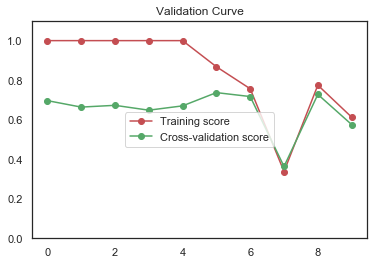

In [492]:
search_results = pd.DataFrame(P5_model_final.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))    
plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)


===============ROC curve on the Test data ...===============



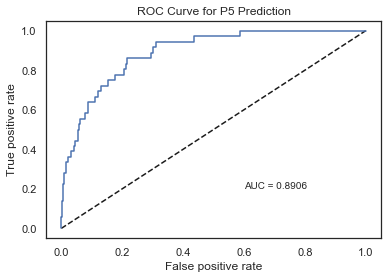

In [493]:
P5_auc = custom_test_function(P5_model_final, X, y_P5, proba=True, name="P5 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



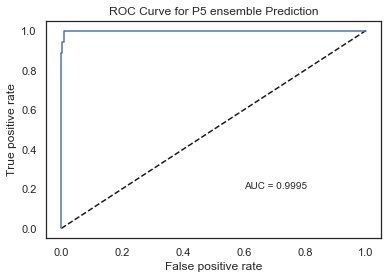

(0.8905665653070498, 0.9994582503233022)

In [494]:
P5_ensemble_model = BaggingClassifier(P5_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P5_ensemble_model = P5_ensemble_model.fit(X, y_P5)
P5_auc_en = custom_test_function(P5_ensemble_model, X, y_P5, proba=True, name="P5 ensemble Prediction")
P5_auc, P5_auc_en

Using bagging classifier for P5 ... 


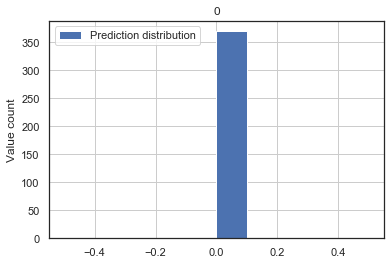

In [495]:
if P5_auc_en > P5_auc:
    print("Using bagging classifier for P5 ... ")
    P5_model_final = P5_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P5 = P5_model_final.predict(X_predict)
P5 = pd.DataFrame(yhat_P5, index=df_predict.index)
P5.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [496]:
df_predict.P5 = P5

First, we can see that only zero are predicted, and that there were only zeros in the training data set, so a dummy classifier would have give the same results. Moreover, the best model is the MLP classifier, followed by the logistic regression one. We can assume that the model has laked of positive case to train on them.

## Prediction P6

    Predict the share price at the end of the first day.


In [542]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P6, test_size=0.2,  random_state=SEED)

In [543]:
# Pipeline
P6_models = get_best_regressors(X_train, y_train)

### Test the trained models on test dataset

In [544]:
linear_reg_score = P6_models[0].score(X_test, y_test)
svr_score = P6_models[1].score(X_test, y_test)
print(f"Linear regression {scoring_metric_regression} score : ", linear_reg_score)
print(f"Support vector regression {scoring_metric_regression} score : ", svr_score)

P6_test_results = pd.DataFrame({'LinearRegressor':-linear_reg_score, 'SVR':-svr_score}, index=[scoring_metric_regression]).T

P6_model_final = P6_models[1] if linear_reg_score > svr_score else P6_models[0]

P6_test_results

Linear regression r2 score :  0.5223602921298587
Support vector regression r2 score :  0.347671691549732


,r2
LinearRegressor,-0.522
SVR,-0.348


### Retrain the final model on entire dataset and check the performance

In [500]:
P6_model_final = P6_model_final.fit(X, y_P6)
P6_r2 = P6_model_final.score(X, y_P6)

In [501]:
print(f"Final regression {scoring_metric_regression} score : ", P6_r2)

Final regression r2 score :  0.26334161421737345


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


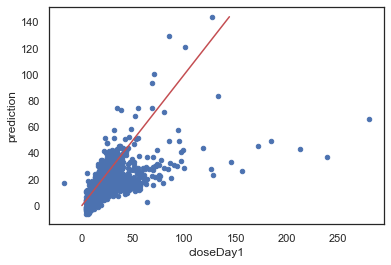

In [502]:
y_hat = P6_model_final.predict(X)
df = pd.DataFrame(y_P6)
df['prediction'] = y_hat
df.plot('closeDay1', 'prediction', kind='scatter')
plt.plot(np.linspace(0, df.prediction.max(), 100), np.linspace(0, df.prediction.max(), 100), 'r', label='Actual')

Test the best base estimator performance with bagging classifier

In [503]:
P6_ensemble_model = AdaBoostRegressor(P6_model_final, n_estimators=n_estimators, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P6_ensemble_model = P6_ensemble_model.fit(X, y_P6)
P6_r2_en = P6_ensemble_model.score(X, y_P6)
P6_r2, P6_r2_en

(0.26334161421737345, 0.13468675234043304)

Using AdaBoostRegressor classifier for P6 ... 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f210d4a7588>]],
      dtype=object)

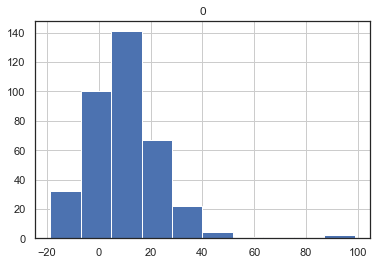

In [504]:
if P6_r2_en < P6_r2:
    print("Using AdaBoostRegressor classifier for P6 ... ")
    P6_model_final = P6_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P6 = P6_model_final.predict(X_predict)
P6 = pd.DataFrame(yhat_P6, index=df_predict.index)
P6.hist()

In [505]:
df_predict.P6 = P6

Here we have used R_2 to score the prediction. The AdaBoostRegressor has been used in order to increase the R_2. The negative values are probably due to a normalization issue.

For the remaining problems, provide a predicted probability (expressed as a number from 0 to 100) that the stated event will happen.
## Prediction P7

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 5% from the original offer price.

Scoring Metric for P7: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score of p * p (i.e., the square of your predicted probability for that event) will be assessed. For predictions where the event turns out to be TRUE, a score of (100 - p) * (100 - p) will be assessed (i.e., the square of 100 minus your predicted probability for that event). Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, then the score for that observation would equal 4,900 (70 * 70 = 4,900); but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 900 (100 - 70 = 30, and 30 * 30 = 900).

In [506]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P7, test_size=0.2,  random_state=SEED)

In [507]:
# Pipeline
P7_models = get_best_classifiers(X_train, y_train, scoring=custom_scorer_P7P8, proba=True, n_components=P3_n_components)

===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-151.589):
{'model__C': 1000.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-156.683):
{'model__n_neighbors': 66}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-162.375):
{'model__max_depth': 1}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   29.6s finished



Best parameter (CV score =-153.766):
{'model__n_estimators': 250}
===============... Training the SVC model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.7s finished



Best parameter (CV score =-156.528):
{'model__C': 3.1622776601683795, 'model__kernel': 'rbf'}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.3s finished



Best parameter (CV score =-153.321):
{'model__alpha': 100.0}


### Test the trained models on test dataset

In [508]:
P7_model_final, P7_test_results = test_final_models(P7_models, X_test, y_test, greater_the_better=True)
P7_test_results[[scoring_metric]]

,roc_auc
RandomForestClassifier,-120.186
MLPClassifier,-120.275
LogisticRegression,-120.919
KNeighborsClassifier,-122.375
SVC,-122.775
DecisionTreeClassifier,-126.195


### Retrain the final model on entire dataset and check the performance

In [509]:
P7_model_final = P7_model_final.fit(X, y_P7)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   36.5s finished


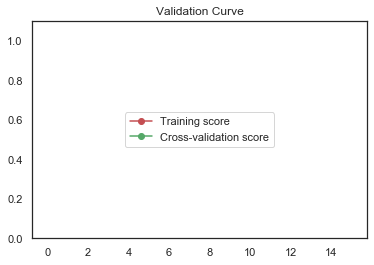

In [510]:
search_results = pd.DataFrame(P7_model_final.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))    
plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)


===============ROC curve on the Test data ...===============



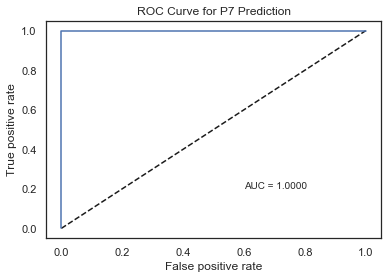

In [511]:
P7_auc = custom_test_function(P7_model_final, X, y_P7, proba=True, name="P7 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



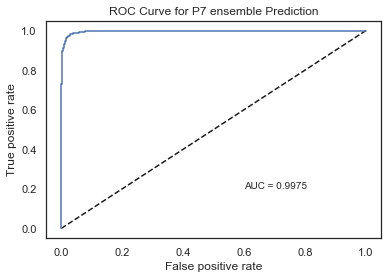

(1.0, 0.9975201019385747)

In [512]:
P7_ensemble_model = BaggingClassifier(P7_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P7_ensemble_model = P7_ensemble_model.fit(X, y_P7)
P7_auc_en = custom_test_function(P7_ensemble_model, X, y_P7, proba=True, name="P7 ensemble Prediction")
P7_auc, P7_auc_en

Using the model without ensembling ...


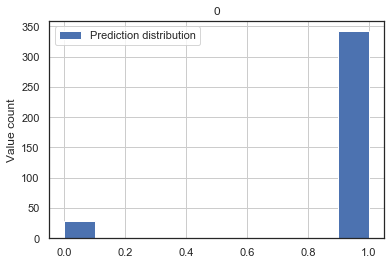

In [513]:
if P7_auc_en > P7_auc:
    print("Using bagging classifier for P7 ... ")
    P7_model_final = P7_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P7 = P7_model_final.predict(X_predict)
P7 = pd.DataFrame(yhat_P7, index=df_predict.index)
P7.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [514]:
df_predict.P7 = P7

Here the random forest 

## Prediction P8

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 50% from the original offer price.

Scoring Metric for P8: Same scoring metric as P7 above. Attempt to tune you prediction model(s) accordingly.

In [515]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P8, test_size=0.2,  random_state=SEED)

In [516]:
# Pipeline
P8_models = get_best_classifiers(X_train, y_train, scoring=custom_scorer_P7P8, proba=True, n_components=P3_n_components)

===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-151.493):
{'model__C': 1.0}
===============... Training the KNN model...===============
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-156.583):
{'model__n_neighbors': 71}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.4s remaining:    0.3s



Best parameter (CV score =-161.837):
{'model__max_depth': 1}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   29.8s finished



Best parameter (CV score =-154.320):
{'model__n_estimators': 250}
===============... Training the SVC model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.8s finished



Best parameter (CV score =-156.581):
{'model__C': 3.1622776601683795, 'model__kernel': 'rbf'}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.0s finished



Best parameter (CV score =-153.191):
{'model__alpha': 100.0}


### Test the trained models on test dataset

In [517]:
P8_model_final, P8_test_results = test_final_models(P8_models, X_test, y_test)
P8_test_results[[scoring_metric]]

,roc_auc
RandomForestClassifier,-119.159
LogisticRegression,-120.750
MLPClassifier,-120.792
SVC,-122.131
KNeighborsClassifier,-122.183
DecisionTreeClassifier,-126.596


In [518]:
### Retrain the final model on entire dataset and check the performance

In [519]:
P8_model_final = P8_model_final.fit(X, y_P8)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   36.6s finished


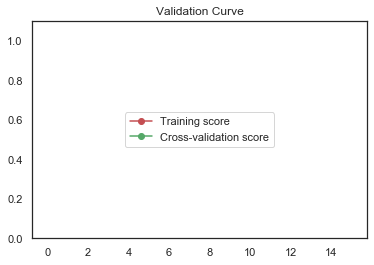

In [520]:
search_results = pd.DataFrame(P8_model_final.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))    
plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)


===============ROC curve on the Test data ...===============



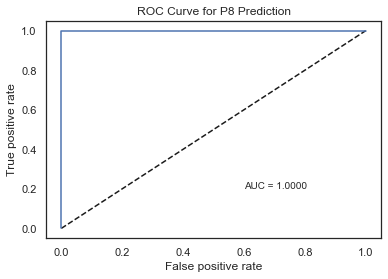

In [521]:
P8_auc = custom_test_function(P8_model_final, X, y_P8, proba=True, name="P8 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



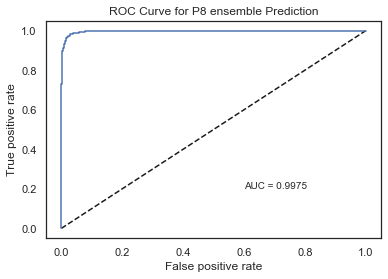

(0.999998999032064, 0.9975201019385747)

In [522]:
P8_ensemble_model = BaggingClassifier(P8_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P8_ensemble_model = P8_ensemble_model.fit(X, y_P8)
P8_auc_en = custom_test_function(P8_ensemble_model, X, y_P8, proba=True, name="P8 ensemble Prediction")
P8_auc, P8_auc_en

Using the model without ensembling ...


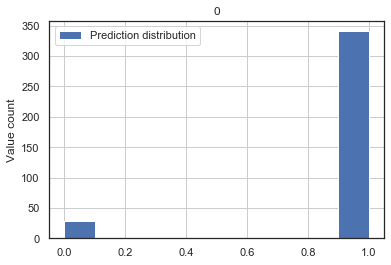

In [523]:
if P8_auc_en > P8_auc:
    print("Using bagging classifier for P8 ... ")
    P8_model_final = P8_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P8 = P8_model_final.predict(X_predict)
P8 = pd.DataFrame(yhat_P8, index=df_predict.index)
P8.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [524]:
df_predict.P8 = P8

## Prediction P9

    Predict the probability that the closing price at the end of the first day of trading will go down (the "positive" case, coded as 1) or not (coded as 0) by more than 10% from the original offer price.

Scoring Metric for P9: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score equal to p will be assessed. For predictions where the event turns out to be TRUE, a score of 2 * (100 - p) will be assessed. Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, the score for that observation would equal 70; but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 2 * (100 - 70) = 60.

In [525]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y_P9, test_size=0.2,  random_state=SEED)

In [526]:
# Pipeline
P9_models = get_best_classifiers(X_train, y_train, scoring=custom_scorer_P9, proba=True, n_components=P3_n_components)

===============... Training the Logit model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-837.333):
{'model__C': 0.0001}
===============... Training the KNN model...===============
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-1558.299):
{'model__n_neighbors': 96}
===============... Training the Decision trees model...===============
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished



Best parameter (CV score =-1540.667):
{'model__max_depth': 29}
===============... Training the Random forests model...===============
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   25.8s finished



Best parameter (CV score =-1546.537):
{'model__n_estimators': 100}
===============... Training the SVC model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished



Best parameter (CV score =-1125.735):
{'model__C': 3.1622776601683795, 'model__kernel': 'linear'}
===============... Training the CNN model...===============
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Best parameter (CV score =-1560.263):
{'model__alpha': 10000.0}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.0s finished


### Test the trained models on test dataset

In [527]:
P9_model_final, P9_test_results = test_final_models(P9_models, X_test, y_test)
P9_test_results[[scoring_metric]]

,roc_auc
LogisticRegression,-631.000
RandomForestClassifier,-1174.700
SVC,-1180.216
MLPClassifier,-1181.364
KNeighborsClassifier,-1183.031
DecisionTreeClassifier,-1191.000


### Retrain the final model on entire dataset and check the performance

In [528]:
P9_model_final = P9_model_final.fit(X, y_P9)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


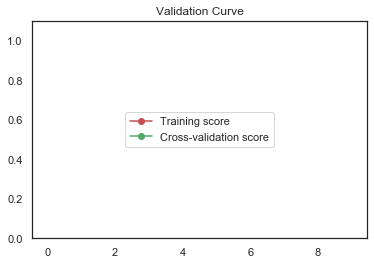

In [529]:
search_results = pd.DataFrame(P9_model_final.cv_results_).filter(regex=("(mean_train_score|mean_test_score|rank_|std_train_score|std_test_score)"))    
plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)


===============ROC curve on the Test data ...===============



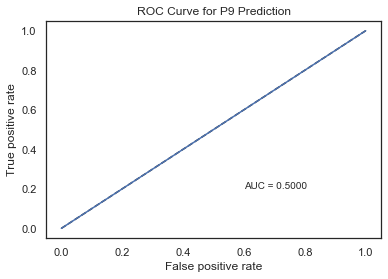

In [530]:
P9_auc = custom_test_function(P9_model_final, X, y_P9, proba=True, name="P9 Prediction")

Test the best base estimator performance with bagging classifier


===============ROC curve on the Test data ...===============



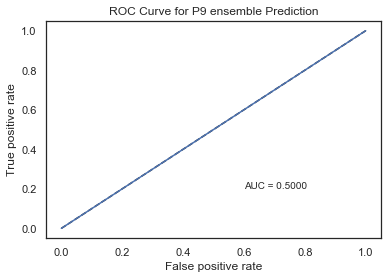

(0.5, 0.5)

In [531]:
P9_ensemble_model = BaggingClassifier(P9_model_final, n_estimators=n_estimators, n_jobs=-1, random_state=SEED)
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
P9_ensemble_model = P9_ensemble_model.fit(X, y_P9)
P9_auc_en = custom_test_function(P9_ensemble_model, X, y_P9, proba=True, name="P9 ensemble Prediction")
P9_auc, P9_auc_en

Using the model without ensembling ...


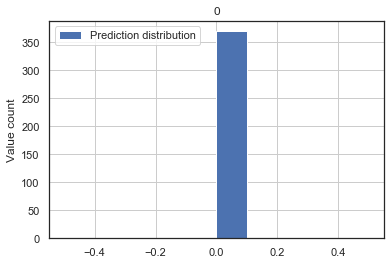

In [532]:
if P9_auc_en > P9_auc:
    print("Using bagging classifier for P9 ... ")
    P9_model_final = P9_ensemble_model 
else :
    print("Using the model without ensembling ...")

yhat_P9 = P9_model_final.predict(X_predict)
P9 = pd.DataFrame(yhat_P9, index=df_predict.index)
P9.hist(label="Prediction distribution"), plt.legend(), plt.ylabel('Value count')
plt.show()

In [533]:
df_predict.P9 = P9

## Summary of results and conculsion

In [534]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]


In [545]:
scores = pd.concat([results[results.columns[0]] for results in [P1_test_results, P2_test_results, P3_test_results, P4_test_results, P5_test_results, P6_test_results, P7_test_results, P8_test_results, P9_test_results]], axis=1)
scores.columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
#scores.fillna(-np.Inf, inplace=True)

In [546]:
scores.style.apply(highlight_max)

,P1,P2,P3,P4,P5,P6,P7,P8,P9
DecisionTreeClassifier,0.591,0.572,0.637,0.727,0.748,nan,-126,-127,-1.19e+03
DummyClassifier,0.5,0.5,0.5,0.5,0.5,nan,nan,nan,nan
DummyClassifier-1,0.5,0.5,0.5,0.5,0.5,nan,nan,nan,nan
KNeighborsClassifier,0.641,0.584,0.641,0.792,0.727,nan,-122,-122,-1.18e+03
LinearRegressor,nan,nan,nan,nan,nan,-0.522,nan,nan,nan
LogisticRegression,0.67,0.591,0.68,0.796,0.782,nan,-121,-121,-631
MLPClassifier,0.673,0.589,0.674,0.79,0.804,nan,-120,-121,-1.18e+03
RandomForestClassifier,0.67,0.562,0.658,0.801,0.627,nan,-120,-119,-1.17e+03
SVC,0.64,0.467,0.645,0.792,0.625,nan,-123,-122,-1.18e+03
SVR,nan,nan,nan,nan,nan,-0.348,nan,nan,nan


In [552]:
df_predict.to_excel('IPO_data_to_predicted.xlsx')